# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 1 in Shi Jin's paper (2008-jy-phase.pdf):
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = e^{-25x^2}, \ S_0(x) = -0.2\log(2\cosh(5x)).
$$

Periodic BC.

Domain: $[-0.5, 0.5]\times [0, 0.5]$.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25x^2}\cos(-0.2\log(2\cosh(5x))/\varepsilon), \ q(x, 0) = e^{-25x^2}\sin(-0.2\log(2\cosh(5x))/\varepsilon),
$$
and bc
$$
p(x_0, t) = p(x_1, t), q(x_0, t) = q(x_1, t), p_x(x_0, t) = p_x(x_1, t), q_x(x_0, t) = q_x(x_1, t).
$$


In [1]:
NAME = "1_extended_domain"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [3] + [32]*2 + [2] # (x, t) -> (u, v)
c0 = 6.0
w0 = jnp.array([[1.0, 1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[-0.5, 0.], [0.5, 0.5]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1.0
V = 10.0

@jax.jit
def model(params, xt): # for predictions
	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[:,0], jnp.sin(2*jnp.pi*xt[:,0]/spatial_width))
	xt = index_update(xt, index[:,1], jnp.cos(2*jnp.pi*xt[:,1]/spatial_width))
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

@jax.jit
def model_(params, xt): # for derivatives
	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[0], jnp.sin(2*jnp.pi*xt[0]/spatial_width))
	xt = index_update(xt, index[1], jnp.cos(2*jnp.pi*xt[1]/spatial_width))
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model_)
hessian = hessian_fn(model_)

In [4]:
metaloss = mse

static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

# jacobian[i] = [[du/dx, du/dt],
#                [dv/dx, dv/dt]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, neumann = batch["collocation"], batch["dirichlet"], batch["neumann"]
	direct_params = params
	
	if collocation[0] is not None:
		uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
		u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
		duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
		duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0]
		loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
		loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
		loss_c = loss_c1 + loss_c2
	else:
		loss_c = 0.0
        
	if dirichlet[0] is not None:
		uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
		u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
		loss_d1 = metaloss(u_d, dirichlet.u)
		loss_d2 = metaloss(v_d, dirichlet.v)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0
	
	if neumann[0] is not None:
		duv_dxt_n = jacobian(direct_params, jnp.hstack([neumann.x, neumann.t]))
		du_dt_n, dv_dt_n = duv_dxt_n[:, 0:1, 1], duv_dxt_n[:, 1:2, 1]
		du_dx_n, dv_dx_n = duv_dxt_n[:, 0:1, 0], duv_dxt_n[:, 1:2, 0]
		duv_dxxtt_n = hessian(direct_params, jnp.hstack([neumann.x, neumann.t]))
		du_dxx_n, dv_dxx_n = duv_dxxtt_n[:, 0:1, 0, 0], duv_dxxtt_n[:, 1:2, 0, 0]
		loss_n_t1 = metaloss(du_dt_n, neumann.du_dt)
		loss_n_t2 = metaloss(dv_dt_n, neumann.dv_dt)
		loss_n_x1 = metaloss(du_dx_n, neumann.du_dx)
		loss_n_x2 = metaloss(dv_dx_n, neumann.dv_dx)
		loss_n_xx1 = metaloss(du_dxx_n, neumann.du_dxx)
		loss_n_xx2 = metaloss(dv_dxx_n, neumann.dv_dxx)
		loss_nt = loss_n_t1 + loss_n_t2
		loss_nx = loss_n_x1 + loss_n_x2
		loss_nxx = loss_n_xx1 + loss_n_xx2
	else:
		loss_nt = loss_nx = loss_nxx = 0.0

	return loss_c, loss_d, loss_nt, loss_nx, loss_nxx

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_nt, loss_nx, loss_nxx = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["nt"]*loss_nt + w["nx"]*loss_nx + w["nxx"]*loss_nxx + \
			l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_nt, loss_nx, loss_nxx = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c"]*loss_c + w["d"]*loss_d + w["nt"]*loss_nt + w["nx"]*loss_nx + w["nxx"]*loss_nxx, \
			loss_c, loss_d, loss_nt, loss_nx, loss_nxx, l1, l2

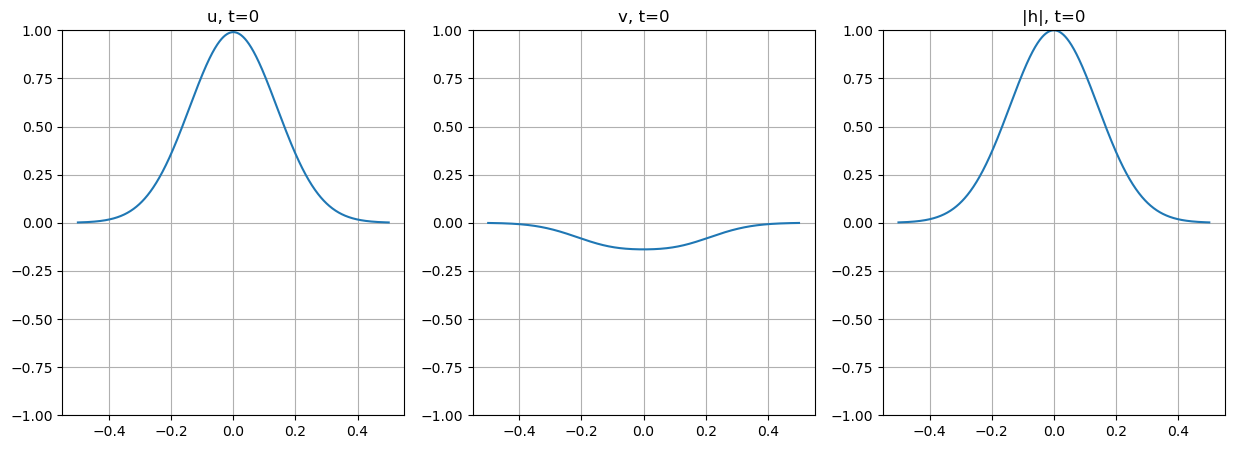

In [5]:
u0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))
v0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))

u0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))
v0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

du0_dxx_fn = lambda xt: jax.vmap(jax.hessian(u0_fn_), in_axes = 0)(xt)[:, 0, 0:1]
dv0_dxx_fn = lambda xt: jax.vmap(jax.hessian(v0_fn_), in_axes = 0)(xt)[:, 0, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 1000
# x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)
du_dxx_i = du0_dxx_fn(jnp.hstack([x_i, t_i]))
dv_dxx_i = dv0_dxx_fn(jnp.hstack([x_i, t_i]))
du_dt_i = 1.0/epsilon*(V*v_i - 1/2*epsilon**2*dv_dxx_i)
dv_dt_i = 1.0/epsilon*(1/2*epsilon**2*du_dxx_i - V*u_i)
du_dx_i = du0_dx_fn(jnp.hstack([x_i, t_i]))
dv_dx_i = dv0_dx_fn(jnp.hstack([x_i, t_i]))

n_cx = 1000
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_Neumann = namedtuple("dataset_Neumann", ["x", "t", "du_dt", "dv_dt", "du_dx", "dv_dx", "du_dxx", "dv_dxx"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
collocation = dataset_Collocation(jnp.vstack([dirichlet.x]),
								 jnp.vstack([dirichlet.t]))
neumann = dataset_Neumann(x_i, t_i, du_dt_i, dv_dt_i, du_dx_i, dv_dx_i, du_dxx_i, dv_dxx_i)

class Time_Marching_Generator:
	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every):
		self.key = key
		self.spatial_points = spatial_points
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = 0
		self._count2 = update_every
		self.update_every = update_every
		
	def _update(self, key, tmax):
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self.key, subkey = random.split(self.key)
			self._update(subkey, tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self.spatial_points, self._t

In [6]:
# pre-train, no bc

lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 100, "collocation": 0, "neumann": 100}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Neumann = Batch_Generator(subkeys[1], neumann, batch_size["neumann"])
# Collocation = Time_Marching_Generator(subkeys[3], x_c, [0.0, 0.0], n_cx, iterations, 1)

start_iteration = 0
iterations = 50000
print_every = 200
save_every = 10000
weights = {"c": 0.0, "d": 1.0, "nt": 1.0, "nx": 1.0, "nxx": 1.0, "l1": 1e-6, "l2": 1e-6}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"neumann": dataset_Neumann(*next(Neumann)),
		"collocation": dataset_Collocation(None, None),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"neumann": dataset_Neumann(*Neumann.dataset),
			"collocation": dataset_Collocation(*Dirichlet.dataset[:2]),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/19, 14:02:41, Iteration: 0, Train Loss: 5.1401e+03, c: 1.8861e+03, d: 7.2244e-01, nt: 2.0167e+02, nx: 3.2329e+01, nxx: 4.9054e+03, l1_reg: 2.9847e+02, l2_reg: 1.2792e+02
2020/08/19, 14:02:43, Iteration: 200, Train Loss: 2.0122e+02, c: 1.8993e+02, d: 1.0730e-02, nt: 1.9223e+02, nx: 5.9601e-03, nxx: 8.9702e+00, l1_reg: 2.9893e+02, l2_reg: 1.2919e+02
2020/08/19, 14:02:46, Iteration: 400, Train Loss: 1.8146e+02, c: 1.8002e+02, d: 4.6594e-04, nt: 1.8082e+02, nx: 1.0498e-03, nxx: 6.3403e-01, l1_reg: 3.0192e+02, l2_reg: 1.3430e+02
2020/08/19, 14:02:49, Iteration: 600, Train Loss: 1.6578e+02, c: 1.6523e+02, d: 8.3461e-05, nt: 1.6556e+02, nx: 1.0165e-03, nxx: 2.2269e-01, l1_reg: 3.0566e+02, l2_reg: 1.4188e+02
2020/08/19, 14:02:51, Iteration: 800, Train Loss: 1.4211e+02, c: 1.4220e+02, d: 3.9115e-04, nt: 1.4176e+02, nx: 1.1792e-03, nxx: 3.4366e-01, l1_reg: 3.1104e+02, l2_reg: 1.5235e+02
2020/08/19, 14:02:54, Iteration: 1000, Train Loss: 9.1790e+01, c: 9.2231e+01, d: 1.6163e-03, nt: 9.118

2020/08/19, 14:04:42, Iteration: 9200, Train Loss: 1.4193e-01, c: 6.1927e-02, d: 2.8716e-05, nt: 1.4455e-02, nx: 1.9018e-03, nxx: 1.2554e-01, l1_reg: 3.4389e+02, l2_reg: 2.2698e+02
2020/08/19, 14:04:44, Iteration: 9400, Train Loss: 7.6517e-02, c: 3.5850e-02, d: 2.8250e-05, nt: 1.4051e-02, nx: 1.4370e-03, nxx: 6.1001e-02, l1_reg: 3.4399e+02, l2_reg: 2.2739e+02
2020/08/19, 14:04:47, Iteration: 9600, Train Loss: 1.1120e-01, c: 4.1547e-02, d: 1.4084e-05, nt: 1.3682e-02, nx: 9.4770e-04, nxx: 9.6559e-02, l1_reg: 3.4404e+02, l2_reg: 2.2754e+02
2020/08/19, 14:04:49, Iteration: 9800, Train Loss: 6.6972e-02, c: 2.4783e-02, d: 1.0089e-05, nt: 1.3395e-02, nx: 6.9264e-04, nxx: 5.2875e-02, l1_reg: 3.4438e+02, l2_reg: 2.2948e+02
2020/08/19, 14:04:52, Iteration: 10000, Train Loss: 6.7688e-02, c: 2.5089e-02, d: 1.4040e-05, nt: 1.3032e-02, nx: 7.6715e-04, nxx: 5.3875e-02, l1_reg: 3.4443e+02, l2_reg: 2.2961e+02
2020/08/19, 14:04:54, Iteration: 10200, Train Loss: 4.9543e-01, c: 1.4842e-01, d: 2.4417e-05, 

2020/08/19, 14:06:41, Iteration: 18400, Train Loss: 1.0175e-01, c: 3.3085e-02, d: 1.1193e-05, nt: 4.5187e-03, nx: 7.9563e-04, nxx: 9.6427e-02, l1_reg: 3.5280e+02, l2_reg: 2.7191e+02
2020/08/19, 14:06:44, Iteration: 18600, Train Loss: 3.1723e-01, c: 1.0106e-01, d: 2.4680e-05, nt: 4.5694e-03, nx: 2.2679e-03, nxx: 3.1037e-01, l1_reg: 3.5306e+02, l2_reg: 2.7333e+02
2020/08/19, 14:06:46, Iteration: 18800, Train Loss: 4.1595e-02, c: 1.5168e-02, d: 1.5260e-05, nt: 4.2940e-03, nx: 8.4747e-04, nxx: 3.6438e-02, l1_reg: 3.5346e+02, l2_reg: 2.7559e+02
2020/08/19, 14:06:49, Iteration: 19000, Train Loss: 4.9158e-02, c: 1.7272e-02, d: 1.6863e-05, nt: 4.2011e-03, nx: 1.0401e-03, nxx: 4.3900e-02, l1_reg: 3.5363e+02, l2_reg: 2.7636e+02
2020/08/19, 14:06:51, Iteration: 19200, Train Loss: 9.0589e-01, c: 2.8421e-01, d: 7.9810e-05, nt: 4.4514e-03, nx: 5.7688e-03, nxx: 8.9559e-01, l1_reg: 3.5385e+02, l2_reg: 2.7750e+02
2020/08/19, 14:06:54, Iteration: 19400, Train Loss: 3.9814e-02, c: 1.4016e-02, d: 1.7071e-

2020/08/19, 14:08:41, Iteration: 27600, Train Loss: 7.5236e-02, c: 2.4609e-02, d: 2.3685e-05, nt: 2.0053e-03, nx: 1.1730e-03, nxx: 7.2034e-02, l1_reg: 3.6583e+02, l2_reg: 3.5692e+02
2020/08/19, 14:08:44, Iteration: 27800, Train Loss: 3.3435e-02, c: 1.2352e-02, d: 1.6238e-05, nt: 1.9450e-03, nx: 9.4412e-04, nxx: 3.0530e-02, l1_reg: 3.6608e+02, l2_reg: 3.5882e+02
2020/08/19, 14:08:46, Iteration: 28000, Train Loss: 2.0991e-01, c: 6.3758e-02, d: 2.0966e-05, nt: 2.0760e-03, nx: 1.4008e-03, nxx: 2.0641e-01, l1_reg: 3.6633e+02, l2_reg: 3.6078e+02
2020/08/19, 14:08:49, Iteration: 28200, Train Loss: 1.7151e-01, c: 5.6938e-02, d: 2.8548e-05, nt: 2.0643e-03, nx: 2.0253e-03, nxx: 1.6740e-01, l1_reg: 3.6680e+02, l2_reg: 3.6443e+02
2020/08/19, 14:08:51, Iteration: 28400, Train Loss: 1.7428e-01, c: 6.2783e-02, d: 4.6424e-05, nt: 2.2907e-03, nx: 2.5516e-03, nxx: 1.6939e-01, l1_reg: 3.6705e+02, l2_reg: 3.6630e+02
2020/08/19, 14:08:54, Iteration: 28600, Train Loss: 9.5585e-02, c: 3.5063e-02, d: 2.3434e-

2020/08/19, 14:10:40, Iteration: 36800, Train Loss: 1.5661e-01, c: 4.6102e-02, d: 1.7167e-05, nt: 1.6898e-03, nx: 1.2657e-03, nxx: 1.5363e-01, l1_reg: 3.7882e+02, l2_reg: 4.7071e+02
2020/08/19, 14:10:43, Iteration: 37000, Train Loss: 3.7656e-02, c: 1.3833e-02, d: 1.4909e-05, nt: 1.3942e-03, nx: 9.9421e-04, nxx: 3.5253e-02, l1_reg: 3.7916e+02, l2_reg: 4.7409e+02
2020/08/19, 14:10:45, Iteration: 37200, Train Loss: 7.1021e-02, c: 2.4096e-02, d: 1.7585e-05, nt: 1.6054e-03, nx: 9.7941e-04, nxx: 6.8418e-02, l1_reg: 3.7926e+02, l2_reg: 4.7512e+02
2020/08/19, 14:10:48, Iteration: 37400, Train Loss: 5.3744e-02, c: 2.0781e-02, d: 2.5731e-05, nt: 1.4111e-03, nx: 1.3741e-03, nxx: 5.0933e-02, l1_reg: 3.7942e+02, l2_reg: 4.7677e+02
2020/08/19, 14:10:51, Iteration: 37600, Train Loss: 4.4516e-02, c: 1.6043e-02, d: 1.6994e-05, nt: 1.3974e-03, nx: 1.0110e-03, nxx: 4.2091e-02, l1_reg: 3.8032e+02, l2_reg: 4.8589e+02
2020/08/19, 14:10:53, Iteration: 37800, Train Loss: 3.7685e-02, c: 1.4888e-02, d: 2.0840e-

2020/08/19, 14:12:41, Iteration: 46000, Train Loss: 6.1373e-02, c: 2.5002e-02, d: 2.4575e-05, nt: 1.3396e-03, nx: 1.3939e-03, nxx: 5.8615e-02, l1_reg: 3.9020e+02, l2_reg: 5.9470e+02
2020/08/19, 14:12:43, Iteration: 46200, Train Loss: 2.9556e-02, c: 1.1540e-02, d: 1.4175e-05, nt: 1.2277e-03, nx: 8.7210e-04, nxx: 2.7442e-02, l1_reg: 3.9037e+02, l2_reg: 5.9683e+02
2020/08/19, 14:12:46, Iteration: 46400, Train Loss: 2.0386e-02, c: 6.7338e-03, d: 1.3485e-05, nt: 1.1410e-03, nx: 7.5721e-04, nxx: 1.8474e-02, l1_reg: 3.9059e+02, l2_reg: 5.9954e+02
2020/08/19, 14:12:48, Iteration: 46600, Train Loss: 3.6168e-02, c: 1.4301e-02, d: 1.7427e-05, nt: 1.1800e-03, nx: 9.9832e-04, nxx: 3.3972e-02, l1_reg: 3.9121e+02, l2_reg: 6.0647e+02
2020/08/19, 14:12:51, Iteration: 46800, Train Loss: 1.1368e-01, c: 2.9623e-02, d: 6.0796e-06, nt: 1.4971e-03, nx: 5.8929e-04, nxx: 1.1158e-01, l1_reg: 3.9130e+02, l2_reg: 6.0764e+02
2020/08/19, 14:12:53, Iteration: 47000, Train Loss: 5.7319e-02, c: 1.8047e-02, d: 1.3572e-

In [11]:
batch_size = {"dirichlet": 100, "collocation": 200, "neumann": 100}
Collocation = Time_Marching_Generator(subkeys[3], x_c, domain[:, 1], n_cx, iterations, 1)

start_iteration = 50000
iterations = 500000
print_every = 500
save_every = 10000
weights = {"c": 1e-1, "d": 1.0, "nt": 1.0, "nx": 1.0, "nxx": 1.0, "l1": 1e-6, "l2": 1e-6}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"neumann": dataset_Neumann(*Neumann.dataset),
			"collocation": dataset_Collocation(*[jnp.vstack([x, y]) for x, y in zip(Dirichlet.dataset, batch["collocation"])]),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/19, 14:34:18, Iteration: 50000, Train Loss: 1.4631e+02, c: 1.4563e+03, d: 3.3398e-04, nt: 7.4554e-02, nx: 8.3018e-03, nxx: 5.9327e-01, l1_reg: 3.9441e+02, l2_reg: 6.4777e+02
2020/08/19, 14:34:26, Iteration: 50500, Train Loss: 2.6589e+00, c: 2.1975e+01, d: 1.5385e-03, nt: 3.3502e-01, nx: 1.0924e-03, nxx: 1.2375e-01, l1_reg: 4.0549e+02, l2_reg: 7.0241e+02
2020/08/19, 14:34:35, Iteration: 51000, Train Loss: 1.7836e+00, c: 1.5127e+01, d: 1.7324e-03, nt: 1.2534e-01, nx: 2.5810e-03, nxx: 1.4128e-01, l1_reg: 4.0985e+02, l2_reg: 7.2556e+02
2020/08/19, 14:34:43, Iteration: 51500, Train Loss: 1.1299e+00, c: 9.8275e+00, d: 1.0437e-03, nt: 7.9798e-02, nx: 1.2665e-03, nxx: 6.5011e-02, l1_reg: 4.1276e+02, l2_reg: 7.4172e+02
2020/08/19, 14:34:51, Iteration: 52000, Train Loss: 1.0552e+00, c: 8.8408e+00, d: 4.9362e-04, nt: 6.3743e-02, nx: 1.6261e-03, nxx: 1.0523e-01, l1_reg: 4.1501e+02, l2_reg: 7.5659e+02
2020/08/19, 14:35:00, Iteration: 52500, Train Loss: 7.2920e-01, c: 6.5066e+00, d: 3.2954e-

2020/08/19, 14:40:40, Iteration: 73000, Train Loss: 2.6757e-01, c: 1.0611e+00, d: 2.8254e-05, nt: 6.6288e-03, nx: 1.1410e-03, nxx: 1.5366e-01, l1_reg: 4.6700e+02, l2_reg: 1.2946e+03
2020/08/19, 14:40:49, Iteration: 73500, Train Loss: 2.2639e-01, c: 1.3702e+00, d: 1.1253e-04, nt: 8.3758e-03, nx: 2.4366e-03, nxx: 7.8450e-02, l1_reg: 4.6746e+02, l2_reg: 1.3011e+03
2020/08/19, 14:40:57, Iteration: 74000, Train Loss: 2.0259e-01, c: 1.2579e+00, d: 3.1485e-05, nt: 5.2963e-03, nx: 1.4728e-03, nxx: 7.0000e-02, l1_reg: 4.6796e+02, l2_reg: 1.3085e+03
2020/08/19, 14:41:05, Iteration: 74500, Train Loss: 1.8666e-01, c: 1.1870e+00, d: 4.0217e-05, nt: 7.7914e-03, nx: 1.4744e-03, nxx: 5.8655e-02, l1_reg: 4.6852e+02, l2_reg: 1.3149e+03
2020/08/19, 14:41:13, Iteration: 75000, Train Loss: 1.9058e-01, c: 1.1120e+00, d: 4.8741e-05, nt: 7.5582e-03, nx: 1.0462e-03, nxx: 7.0727e-02, l1_reg: 4.6904e+02, l2_reg: 1.3212e+03
2020/08/19, 14:41:22, Iteration: 75500, Train Loss: 2.0457e-01, c: 1.3195e+00, d: 6.0182e-

2020/08/19, 14:47:00, Iteration: 96000, Train Loss: 1.3789e-01, c: 8.6831e-01, d: 2.6661e-05, nt: 8.3816e-03, nx: 7.2923e-04, nxx: 4.1918e-02, l1_reg: 4.8490e+02, l2_reg: 1.5196e+03
2020/08/19, 14:47:08, Iteration: 96500, Train Loss: 1.1359e-01, c: 8.7329e-01, d: 2.0624e-05, nt: 3.0394e-03, nx: 1.0735e-03, nxx: 2.2131e-02, l1_reg: 4.8517e+02, l2_reg: 1.5223e+03
2020/08/19, 14:47:16, Iteration: 97000, Train Loss: 1.1237e-01, c: 7.9086e-01, d: 5.0209e-05, nt: 3.6151e-03, nx: 9.4134e-04, nxx: 2.8682e-02, l1_reg: 4.8539e+02, l2_reg: 1.5262e+03
2020/08/19, 14:47:25, Iteration: 97500, Train Loss: 1.1431e-01, c: 8.9284e-01, d: 3.0717e-05, nt: 5.5423e-03, nx: 1.2005e-03, nxx: 1.8248e-02, l1_reg: 4.8569e+02, l2_reg: 1.5290e+03
2020/08/19, 14:47:33, Iteration: 98000, Train Loss: 1.4159e-01, c: 9.4409e-01, d: 4.3678e-05, nt: 5.8729e-03, nx: 8.8094e-04, nxx: 4.0379e-02, l1_reg: 4.8590e+02, l2_reg: 1.5323e+03
2020/08/19, 14:47:41, Iteration: 98500, Train Loss: 1.1361e-01, c: 8.8358e-01, d: 1.8122e-

2020/08/19, 14:53:10, Iteration: 118500, Train Loss: 9.3773e-02, c: 6.6838e-01, d: 9.6656e-06, nt: 4.3502e-03, nx: 4.8320e-04, nxx: 2.2091e-02, l1_reg: 4.9620e+02, l2_reg: 1.6294e+03
2020/08/19, 14:53:18, Iteration: 119000, Train Loss: 9.6674e-02, c: 6.2045e-01, d: 1.9340e-05, nt: 3.7768e-03, nx: 1.0741e-03, nxx: 2.9759e-02, l1_reg: 4.9641e+02, l2_reg: 1.6306e+03
2020/08/19, 14:53:26, Iteration: 119500, Train Loss: 9.5974e-02, c: 6.3123e-01, d: 1.6533e-05, nt: 4.3554e-03, nx: 8.8249e-04, nxx: 2.7596e-02, l1_reg: 4.9661e+02, l2_reg: 1.6319e+03
2020/08/19, 14:53:35, Iteration: 120000, Train Loss: 1.4152e-01, c: 7.0739e-01, d: 2.7335e-05, nt: 6.0413e-03, nx: 1.4952e-03, nxx: 6.3215e-02, l1_reg: 4.9683e+02, l2_reg: 1.6337e+03
2020/08/19, 14:53:43, Iteration: 120500, Train Loss: 1.0380e-01, c: 6.5746e-01, d: 1.1851e-05, nt: 8.1964e-03, nx: 5.8279e-04, nxx: 2.9266e-02, l1_reg: 4.9704e+02, l2_reg: 1.6347e+03
2020/08/19, 14:53:51, Iteration: 121000, Train Loss: 8.1097e-02, c: 5.7459e-01, d: 1.

2020/08/19, 14:59:20, Iteration: 141000, Train Loss: 9.1689e-02, c: 5.1049e-01, d: 1.8027e-05, nt: 8.6305e-03, nx: 1.1324e-03, nxx: 3.0859e-02, l1_reg: 5.0578e+02, l2_reg: 1.6900e+03
2020/08/19, 14:59:28, Iteration: 141500, Train Loss: 9.2908e-02, c: 5.1356e-01, d: 2.6061e-05, nt: 4.9827e-03, nx: 1.2322e-03, nxx: 3.5311e-02, l1_reg: 5.0603e+02, l2_reg: 1.6916e+03
2020/08/19, 14:59:36, Iteration: 142000, Train Loss: 9.1562e-02, c: 4.3312e-01, d: 5.4033e-05, nt: 8.8741e-03, nx: 1.0478e-03, nxx: 3.8274e-02, l1_reg: 5.0626e+02, l2_reg: 1.6928e+03
2020/08/19, 14:59:44, Iteration: 142500, Train Loss: 7.5468e-02, c: 5.0739e-01, d: 5.5543e-05, nt: 1.9395e-03, nx: 1.0287e-03, nxx: 2.1705e-02, l1_reg: 5.0647e+02, l2_reg: 1.6941e+03
2020/08/19, 14:59:53, Iteration: 143000, Train Loss: 1.2281e-01, c: 4.1556e-01, d: 7.9186e-05, nt: 1.1840e-02, nx: 1.4356e-03, nxx: 6.7898e-02, l1_reg: 5.0672e+02, l2_reg: 1.6953e+03
2020/08/19, 15:00:01, Iteration: 143500, Train Loss: 1.2180e-01, c: 5.3833e-01, d: 3.

2020/08/19, 15:05:30, Iteration: 163500, Train Loss: 9.7346e-02, c: 3.2782e-01, d: 2.5457e-05, nt: 5.8666e-03, nx: 1.5050e-03, nxx: 5.7167e-02, l1_reg: 5.1570e+02, l2_reg: 1.7523e+03
2020/08/19, 15:05:38, Iteration: 164000, Train Loss: 8.4745e-02, c: 3.8355e-01, d: 6.5901e-05, nt: 9.5235e-03, nx: 1.7965e-03, nxx: 3.5004e-02, l1_reg: 5.1587e+02, l2_reg: 1.7536e+03
2020/08/19, 15:05:46, Iteration: 164500, Train Loss: 8.5217e-02, c: 3.8651e-01, d: 3.3039e-05, nt: 6.6383e-03, nx: 7.1516e-04, nxx: 3.9180e-02, l1_reg: 5.1609e+02, l2_reg: 1.7552e+03
2020/08/19, 15:05:54, Iteration: 165000, Train Loss: 6.9029e-02, c: 2.9256e-01, d: 5.8852e-05, nt: 9.5921e-03, nx: 8.8457e-04, nxx: 2.9237e-02, l1_reg: 5.1628e+02, l2_reg: 1.7565e+03
2020/08/19, 15:06:02, Iteration: 165500, Train Loss: 1.4328e-01, c: 3.8322e-01, d: 5.3176e-05, nt: 5.8505e-03, nx: 1.5366e-03, nxx: 9.7516e-02, l1_reg: 5.1639e+02, l2_reg: 1.7574e+03
2020/08/19, 15:06:11, Iteration: 166000, Train Loss: 1.0202e-01, c: 4.0369e-01, d: 4.

2020/08/19, 15:11:39, Iteration: 186000, Train Loss: 5.8537e-02, c: 3.0457e-01, d: 9.2878e-05, nt: 3.7433e-03, nx: 1.5257e-03, nxx: 2.2719e-02, l1_reg: 5.2154e+02, l2_reg: 1.7972e+03
2020/08/19, 15:11:47, Iteration: 186500, Train Loss: 8.8281e-02, c: 3.0115e-01, d: 1.8360e-05, nt: 9.0201e-03, nx: 7.3822e-04, nxx: 4.8390e-02, l1_reg: 5.2165e+02, l2_reg: 1.7982e+03
2020/08/19, 15:11:55, Iteration: 187000, Train Loss: 4.5985e-02, c: 2.3721e-01, d: 4.1439e-05, nt: 7.0132e-03, nx: 5.9480e-04, nxx: 1.4614e-02, l1_reg: 5.2170e+02, l2_reg: 1.7987e+03
2020/08/19, 15:12:03, Iteration: 187500, Train Loss: 6.1232e-02, c: 2.8696e-01, d: 4.5059e-05, nt: 3.5994e-03, nx: 9.6797e-04, nxx: 2.7924e-02, l1_reg: 5.2181e+02, l2_reg: 1.7996e+03
2020/08/19, 15:12:12, Iteration: 188000, Train Loss: 5.2396e-02, c: 2.9251e-01, d: 3.8912e-05, nt: 6.8553e-03, nx: 9.3145e-04, nxx: 1.5319e-02, l1_reg: 5.2189e+02, l2_reg: 1.8005e+03
2020/08/19, 15:12:20, Iteration: 188500, Train Loss: 8.1109e-02, c: 3.2477e-01, d: 1.

2020/08/19, 15:17:47, Iteration: 208500, Train Loss: 6.5511e-02, c: 2.9977e-01, d: 5.4083e-05, nt: 8.5787e-03, nx: 1.0515e-03, nxx: 2.5850e-02, l1_reg: 5.2539e+02, l2_reg: 1.8251e+03
2020/08/19, 15:17:55, Iteration: 209000, Train Loss: 5.9446e-02, c: 2.2194e-01, d: 5.1192e-05, nt: 9.2832e-03, nx: 1.3410e-03, nxx: 2.6577e-02, l1_reg: 5.2547e+02, l2_reg: 1.8258e+03
2020/08/19, 15:18:04, Iteration: 209500, Train Loss: 5.1663e-02, c: 2.7998e-01, d: 7.0964e-05, nt: 4.2261e-03, nx: 5.4430e-04, nxx: 1.8824e-02, l1_reg: 5.2555e+02, l2_reg: 1.8261e+03
2020/08/19, 15:18:12, Iteration: 210000, Train Loss: 5.0031e-02, c: 3.1530e-01, d: 5.9364e-05, nt: 2.4462e-03, nx: 5.4973e-04, nxx: 1.5446e-02, l1_reg: 5.2563e+02, l2_reg: 1.8265e+03
2020/08/19, 15:18:20, Iteration: 210500, Train Loss: 5.2492e-02, c: 2.3894e-01, d: 5.3115e-05, nt: 5.1717e-03, nx: 7.9771e-04, nxx: 2.2576e-02, l1_reg: 5.2572e+02, l2_reg: 1.8272e+03
2020/08/19, 15:18:28, Iteration: 211000, Train Loss: 4.8210e-02, c: 2.5822e-01, d: 6.

2020/08/19, 15:23:55, Iteration: 231000, Train Loss: 4.9174e-02, c: 2.1436e-01, d: 3.9862e-05, nt: 3.2659e-03, nx: 9.4965e-04, nxx: 2.3482e-02, l1_reg: 5.2947e+02, l2_reg: 1.8461e+03
2020/08/19, 15:24:03, Iteration: 231500, Train Loss: 4.8137e-02, c: 2.2603e-01, d: 2.1806e-05, nt: 4.2237e-03, nx: 9.6713e-04, nxx: 2.0321e-02, l1_reg: 5.2955e+02, l2_reg: 1.8462e+03
2020/08/19, 15:24:11, Iteration: 232000, Train Loss: 4.7658e-02, c: 2.1362e-01, d: 1.8240e-05, nt: 7.6781e-03, nx: 6.3720e-04, nxx: 1.7963e-02, l1_reg: 5.2964e+02, l2_reg: 1.8469e+03
2020/08/19, 15:24:20, Iteration: 232500, Train Loss: 6.2221e-02, c: 3.0750e-01, d: 3.8523e-05, nt: 9.4011e-03, nx: 7.7630e-04, nxx: 2.1255e-02, l1_reg: 5.2976e+02, l2_reg: 1.8476e+03
2020/08/19, 15:24:28, Iteration: 233000, Train Loss: 5.2534e-02, c: 2.2843e-01, d: 3.9104e-05, nt: 5.4195e-03, nx: 1.1072e-03, nxx: 2.3126e-02, l1_reg: 5.2986e+02, l2_reg: 1.8478e+03
2020/08/19, 15:24:36, Iteration: 233500, Train Loss: 4.6347e-02, c: 1.9442e-01, d: 1.

2020/08/19, 15:30:05, Iteration: 253500, Train Loss: 4.0002e-02, c: 2.1922e-01, d: 2.2914e-05, nt: 3.0207e-03, nx: 8.0233e-04, nxx: 1.4234e-02, l1_reg: 5.3377e+02, l2_reg: 1.8665e+03
2020/08/19, 15:30:13, Iteration: 254000, Train Loss: 4.4588e-02, c: 1.9065e-01, d: 2.5387e-05, nt: 3.1431e-03, nx: 8.3695e-04, nxx: 2.1517e-02, l1_reg: 5.3386e+02, l2_reg: 1.8669e+03
2020/08/19, 15:30:21, Iteration: 254500, Train Loss: 7.8423e-02, c: 2.3573e-01, d: 5.2052e-05, nt: 7.1229e-03, nx: 1.5903e-03, nxx: 4.6085e-02, l1_reg: 5.3396e+02, l2_reg: 1.8674e+03
2020/08/19, 15:30:30, Iteration: 255000, Train Loss: 7.5171e-02, c: 1.9874e-01, d: 3.5705e-05, nt: 1.7903e-02, nx: 6.1077e-04, nxx: 3.6748e-02, l1_reg: 5.3405e+02, l2_reg: 1.8677e+03
2020/08/19, 15:30:38, Iteration: 255500, Train Loss: 5.3551e-02, c: 2.7296e-01, d: 1.3693e-05, nt: 4.2471e-03, nx: 7.8633e-04, nxx: 2.1208e-02, l1_reg: 5.3414e+02, l2_reg: 1.8683e+03
2020/08/19, 15:30:46, Iteration: 256000, Train Loss: 6.0654e-02, c: 2.2001e-01, d: 2.

2020/08/19, 15:36:16, Iteration: 276000, Train Loss: 7.7025e-02, c: 2.3286e-01, d: 3.1468e-05, nt: 1.8242e-02, nx: 8.0273e-04, nxx: 3.4663e-02, l1_reg: 5.3820e+02, l2_reg: 1.8918e+03
2020/08/19, 15:36:24, Iteration: 276500, Train Loss: 3.9563e-02, c: 1.7175e-01, d: 6.8915e-05, nt: 2.0013e-03, nx: 9.2161e-04, nxx: 1.9396e-02, l1_reg: 5.3831e+02, l2_reg: 1.8926e+03
2020/08/19, 15:36:32, Iteration: 277000, Train Loss: 4.1799e-02, c: 1.8594e-01, d: 2.5904e-05, nt: 2.3830e-03, nx: 8.2186e-04, nxx: 1.9974e-02, l1_reg: 5.3841e+02, l2_reg: 1.8931e+03
2020/08/19, 15:36:40, Iteration: 277500, Train Loss: 3.6921e-02, c: 1.6256e-01, d: 2.1724e-05, nt: 2.2186e-03, nx: 5.0977e-04, nxx: 1.7914e-02, l1_reg: 5.3848e+02, l2_reg: 1.8934e+03
2020/08/19, 15:36:48, Iteration: 278000, Train Loss: 4.3790e-02, c: 1.7466e-01, d: 2.8562e-05, nt: 8.4478e-03, nx: 9.8946e-04, nxx: 1.6858e-02, l1_reg: 5.3856e+02, l2_reg: 1.8940e+03
2020/08/19, 15:36:56, Iteration: 278500, Train Loss: 5.4611e-02, c: 2.2593e-01, d: 2.

2020/08/19, 15:42:26, Iteration: 298500, Train Loss: 3.7075e-02, c: 1.5525e-01, d: 5.8410e-05, nt: 2.8951e-03, nx: 7.3054e-04, nxx: 1.7866e-02, l1_reg: 5.4167e+02, l2_reg: 1.9142e+03
2020/08/19, 15:42:34, Iteration: 299000, Train Loss: 4.3268e-02, c: 1.5563e-01, d: 4.2364e-05, nt: 3.5720e-03, nx: 9.3854e-04, nxx: 2.3153e-02, l1_reg: 5.4173e+02, l2_reg: 1.9147e+03
2020/08/19, 15:42:42, Iteration: 299500, Train Loss: 3.8457e-02, c: 1.7236e-01, d: 3.5689e-05, nt: 4.6096e-03, nx: 6.8931e-04, nxx: 1.5887e-02, l1_reg: 5.4181e+02, l2_reg: 1.9149e+03
2020/08/19, 15:42:51, Iteration: 300000, Train Loss: 5.3369e-02, c: 1.8115e-01, d: 1.4917e-05, nt: 8.3689e-03, nx: 6.3647e-04, nxx: 2.6234e-02, l1_reg: 5.4187e+02, l2_reg: 1.9154e+03
2020/08/19, 15:42:59, Iteration: 300500, Train Loss: 3.2313e-02, c: 1.2967e-01, d: 4.9922e-05, nt: 3.2763e-03, nx: 7.2032e-04, nxx: 1.5299e-02, l1_reg: 5.4191e+02, l2_reg: 1.9155e+03
2020/08/19, 15:43:07, Iteration: 301000, Train Loss: 4.3801e-02, c: 1.8783e-01, d: 2.

2020/08/19, 15:48:36, Iteration: 321000, Train Loss: 6.1335e-02, c: 1.5995e-01, d: 4.1607e-05, nt: 8.8139e-03, nx: 1.1012e-03, nxx: 3.5383e-02, l1_reg: 5.4413e+02, l2_reg: 1.9319e+03
2020/08/19, 15:48:44, Iteration: 321500, Train Loss: 5.1604e-02, c: 2.0222e-01, d: 1.9588e-05, nt: 9.2319e-03, nx: 6.5578e-04, nxx: 2.1475e-02, l1_reg: 5.4417e+02, l2_reg: 1.9322e+03
2020/08/19, 15:48:52, Iteration: 322000, Train Loss: 4.2606e-02, c: 1.8890e-01, d: 4.6350e-05, nt: 4.2107e-03, nx: 1.1431e-03, nxx: 1.8316e-02, l1_reg: 5.4422e+02, l2_reg: 1.9326e+03
2020/08/19, 15:49:00, Iteration: 322500, Train Loss: 3.9492e-02, c: 1.5393e-01, d: 2.8547e-05, nt: 2.2457e-03, nx: 8.9361e-04, nxx: 2.0932e-02, l1_reg: 5.4428e+02, l2_reg: 1.9332e+03
2020/08/19, 15:49:09, Iteration: 323000, Train Loss: 3.7763e-02, c: 2.1241e-01, d: 4.7400e-05, nt: 2.5153e-03, nx: 9.4429e-04, nxx: 1.3015e-02, l1_reg: 5.4433e+02, l2_reg: 1.9336e+03
2020/08/19, 15:49:17, Iteration: 323500, Train Loss: 5.4702e-02, c: 1.7422e-01, d: 3.

2020/08/19, 15:54:46, Iteration: 343500, Train Loss: 5.9509e-02, c: 2.0126e-01, d: 2.3308e-05, nt: 1.2409e-02, nx: 9.9700e-04, nxx: 2.5954e-02, l1_reg: 5.4677e+02, l2_reg: 1.9566e+03
2020/08/19, 15:54:54, Iteration: 344000, Train Loss: 3.9415e-02, c: 1.5916e-01, d: 2.7060e-05, nt: 7.2983e-03, nx: 8.6310e-04, nxx: 1.5311e-02, l1_reg: 5.4687e+02, l2_reg: 1.9576e+03
2020/08/19, 15:55:02, Iteration: 344500, Train Loss: 5.0910e-02, c: 2.1499e-01, d: 5.1258e-05, nt: 1.0699e-02, nx: 1.0153e-03, nxx: 1.7645e-02, l1_reg: 5.4694e+02, l2_reg: 1.9584e+03
2020/08/19, 15:55:11, Iteration: 345000, Train Loss: 3.7011e-02, c: 1.3173e-01, d: 2.3583e-05, nt: 2.8497e-03, nx: 7.3491e-04, nxx: 2.0230e-02, l1_reg: 5.4698e+02, l2_reg: 1.9590e+03
2020/08/19, 15:55:19, Iteration: 345500, Train Loss: 4.4917e-02, c: 1.6394e-01, d: 3.7058e-05, nt: 5.2964e-03, nx: 7.7828e-04, nxx: 2.2412e-02, l1_reg: 5.4705e+02, l2_reg: 1.9596e+03
2020/08/19, 15:55:27, Iteration: 346000, Train Loss: 4.0198e-02, c: 1.6380e-01, d: 1.

2020/08/19, 16:00:56, Iteration: 366000, Train Loss: 3.7030e-02, c: 1.4566e-01, d: 3.0966e-05, nt: 2.3534e-03, nx: 9.0673e-04, nxx: 1.9173e-02, l1_reg: 5.4956e+02, l2_reg: 1.9827e+03
2020/08/19, 16:01:04, Iteration: 366500, Train Loss: 4.2892e-02, c: 1.5473e-01, d: 4.8008e-05, nt: 7.7481e-03, nx: 7.5515e-04, nxx: 1.8867e-02, l1_reg: 5.4959e+02, l2_reg: 1.9827e+03
2020/08/19, 16:01:13, Iteration: 367000, Train Loss: 3.5615e-02, c: 1.2344e-01, d: 2.9885e-05, nt: 5.1733e-03, nx: 7.1261e-04, nxx: 1.7355e-02, l1_reg: 5.4965e+02, l2_reg: 1.9831e+03
2020/08/19, 16:01:21, Iteration: 367500, Train Loss: 4.5501e-02, c: 1.8095e-01, d: 4.0718e-05, nt: 6.4454e-03, nx: 9.0813e-04, nxx: 2.0012e-02, l1_reg: 5.4966e+02, l2_reg: 1.9832e+03
2020/08/19, 16:01:29, Iteration: 368000, Train Loss: 3.9093e-02, c: 1.4050e-01, d: 3.7936e-05, nt: 3.8550e-03, nx: 4.8389e-04, nxx: 2.0667e-02, l1_reg: 5.4974e+02, l2_reg: 1.9838e+03
2020/08/19, 16:01:38, Iteration: 368500, Train Loss: 4.8373e-02, c: 1.3863e-01, d: 3.

2020/08/19, 16:07:07, Iteration: 388500, Train Loss: 5.3751e-02, c: 1.7032e-01, d: 1.4415e-05, nt: 1.2260e-02, nx: 6.6745e-04, nxx: 2.3778e-02, l1_reg: 5.5137e+02, l2_reg: 1.9910e+03
2020/08/19, 16:07:15, Iteration: 389000, Train Loss: 3.7578e-02, c: 1.5150e-01, d: 2.7279e-05, nt: 4.6886e-03, nx: 7.4925e-04, nxx: 1.6963e-02, l1_reg: 5.5141e+02, l2_reg: 1.9911e+03
2020/08/19, 16:07:23, Iteration: 389500, Train Loss: 3.7747e-02, c: 1.3431e-01, d: 4.2632e-05, nt: 5.1350e-03, nx: 6.3095e-04, nxx: 1.8507e-02, l1_reg: 5.5145e+02, l2_reg: 1.9912e+03
2020/08/19, 16:07:32, Iteration: 390000, Train Loss: 3.6921e-02, c: 1.4310e-01, d: 4.9614e-05, nt: 4.5736e-03, nx: 6.6942e-04, nxx: 1.7318e-02, l1_reg: 5.5147e+02, l2_reg: 1.9910e+03
2020/08/19, 16:07:40, Iteration: 390500, Train Loss: 3.5477e-02, c: 1.2128e-01, d: 2.7919e-05, nt: 2.6437e-03, nx: 6.4546e-04, nxx: 2.0032e-02, l1_reg: 5.5155e+02, l2_reg: 1.9914e+03
2020/08/19, 16:07:48, Iteration: 391000, Train Loss: 3.9695e-02, c: 1.3540e-01, d: 1.

2020/08/19, 16:13:16, Iteration: 411000, Train Loss: 3.7094e-02, c: 1.6529e-01, d: 6.5453e-05, nt: 4.0421e-03, nx: 8.1673e-04, nxx: 1.5640e-02, l1_reg: 5.5296e+02, l2_reg: 1.9905e+03
2020/08/19, 16:13:24, Iteration: 411500, Train Loss: 3.0998e-02, c: 1.2780e-01, d: 2.4567e-05, nt: 1.8815e-03, nx: 1.0303e-03, nxx: 1.5282e-02, l1_reg: 5.5304e+02, l2_reg: 1.9906e+03
2020/08/19, 16:13:32, Iteration: 412000, Train Loss: 3.7899e-02, c: 1.6569e-01, d: 4.9483e-05, nt: 3.9614e-03, nx: 1.0589e-03, nxx: 1.6261e-02, l1_reg: 5.5309e+02, l2_reg: 1.9906e+03
2020/08/19, 16:13:40, Iteration: 412500, Train Loss: 3.8827e-02, c: 1.4329e-01, d: 2.5130e-05, nt: 9.0650e-03, nx: 7.3280e-04, nxx: 1.4675e-02, l1_reg: 5.5312e+02, l2_reg: 1.9904e+03
2020/08/19, 16:13:49, Iteration: 413000, Train Loss: 3.8612e-02, c: 1.7461e-01, d: 2.1693e-05, nt: 5.0108e-03, nx: 9.7796e-04, nxx: 1.5141e-02, l1_reg: 5.5316e+02, l2_reg: 1.9903e+03
2020/08/19, 16:13:57, Iteration: 413500, Train Loss: 4.0058e-02, c: 1.4098e-01, d: 3.

2020/08/19, 16:19:24, Iteration: 433500, Train Loss: 3.1660e-02, c: 1.3201e-01, d: 2.9522e-05, nt: 3.3025e-03, nx: 9.6087e-04, nxx: 1.4166e-02, l1_reg: 5.5501e+02, l2_reg: 1.9884e+03
2020/08/19, 16:19:32, Iteration: 434000, Train Loss: 3.0714e-02, c: 1.3636e-01, d: 1.5909e-05, nt: 2.3660e-03, nx: 6.3973e-04, nxx: 1.4057e-02, l1_reg: 5.5507e+02, l2_reg: 1.9885e+03
2020/08/19, 16:19:40, Iteration: 434500, Train Loss: 3.3243e-02, c: 1.4394e-01, d: 1.4213e-05, nt: 4.2641e-03, nx: 5.7734e-04, nxx: 1.3993e-02, l1_reg: 5.5512e+02, l2_reg: 1.9883e+03
2020/08/19, 16:19:48, Iteration: 435000, Train Loss: 3.8731e-02, c: 1.3255e-01, d: 3.3068e-05, nt: 6.9878e-03, nx: 7.3545e-04, nxx: 1.7719e-02, l1_reg: 5.5515e+02, l2_reg: 1.9882e+03
2020/08/19, 16:19:57, Iteration: 435500, Train Loss: 3.9181e-02, c: 1.6058e-01, d: 2.3043e-05, nt: 3.4610e-03, nx: 1.0469e-03, nxx: 1.8592e-02, l1_reg: 5.5520e+02, l2_reg: 1.9882e+03
2020/08/19, 16:20:05, Iteration: 436000, Train Loss: 5.2282e-02, c: 1.2483e-01, d: 6.

2020/08/19, 16:25:32, Iteration: 456000, Train Loss: 3.6940e-02, c: 1.2711e-01, d: 7.4210e-05, nt: 4.4232e-03, nx: 9.3606e-04, nxx: 1.8795e-02, l1_reg: 5.5739e+02, l2_reg: 1.9885e+03
2020/08/19, 16:25:40, Iteration: 456500, Train Loss: 3.3450e-02, c: 1.5557e-01, d: 1.9602e-05, nt: 3.3017e-03, nx: 8.8156e-04, nxx: 1.3690e-02, l1_reg: 5.5748e+02, l2_reg: 1.9886e+03
2020/08/19, 16:25:49, Iteration: 457000, Train Loss: 3.2377e-02, c: 1.4046e-01, d: 1.2644e-05, nt: 5.1747e-03, nx: 7.2616e-04, nxx: 1.2418e-02, l1_reg: 5.5754e+02, l2_reg: 1.9887e+03
2020/08/19, 16:25:57, Iteration: 457500, Train Loss: 3.8162e-02, c: 1.4531e-01, d: 1.3764e-05, nt: 6.4593e-03, nx: 6.6936e-04, nxx: 1.6488e-02, l1_reg: 5.5763e+02, l2_reg: 1.9890e+03
2020/08/19, 16:26:05, Iteration: 458000, Train Loss: 3.3146e-02, c: 1.4854e-01, d: 4.1909e-05, nt: 2.1738e-03, nx: 7.3959e-04, nxx: 1.5336e-02, l1_reg: 5.5768e+02, l2_reg: 1.9890e+03
2020/08/19, 16:26:13, Iteration: 458500, Train Loss: 3.7809e-02, c: 1.3220e-01, d: 7.

2020/08/19, 16:33:20, Iteration: 484500, Train Loss: 2.9165e-02, c: 1.0860e-01, d: 2.8189e-05, nt: 3.0295e-03, nx: 1.0668e-03, nxx: 1.4181e-02, l1_reg: 5.6090e+02, l2_reg: 1.9967e+03
2020/08/19, 16:33:28, Iteration: 485000, Train Loss: 2.8993e-02, c: 1.1899e-01, d: 1.3646e-05, nt: 3.4605e-03, nx: 6.8788e-04, nxx: 1.2932e-02, l1_reg: 5.6095e+02, l2_reg: 1.9968e+03
2020/08/19, 16:33:36, Iteration: 485500, Train Loss: 6.5947e-02, c: 1.3542e-01, d: 1.4583e-05, nt: 1.2536e-02, nx: 9.1660e-04, nxx: 3.8937e-02, l1_reg: 5.6096e+02, l2_reg: 1.9967e+03
2020/08/19, 16:33:45, Iteration: 486000, Train Loss: 3.0894e-02, c: 1.1912e-01, d: 1.4908e-05, nt: 1.6371e-03, nx: 7.8123e-04, nxx: 1.6549e-02, l1_reg: 5.6099e+02, l2_reg: 1.9969e+03
2020/08/19, 16:33:53, Iteration: 486500, Train Loss: 3.3311e-02, c: 1.1363e-01, d: 3.9123e-05, nt: 2.6213e-03, nx: 1.1084e-03, nxx: 1.8179e-02, l1_reg: 5.6106e+02, l2_reg: 1.9970e+03
2020/08/19, 16:34:01, Iteration: 487000, Train Loss: 4.6104e-02, c: 1.2881e-01, d: 3.

2020/08/19, 16:39:28, Iteration: 507000, Train Loss: 3.1665e-02, c: 1.0767e-01, d: 3.2690e-05, nt: 4.2903e-03, nx: 9.1569e-04, nxx: 1.5659e-02, l1_reg: 5.6228e+02, l2_reg: 2.0041e+03
2020/08/19, 16:39:36, Iteration: 507500, Train Loss: 2.8026e-02, c: 1.0493e-01, d: 5.6031e-05, nt: 2.0392e-03, nx: 9.6295e-04, nxx: 1.4475e-02, l1_reg: 5.6232e+02, l2_reg: 2.0044e+03
2020/08/19, 16:39:45, Iteration: 508000, Train Loss: 2.9949e-02, c: 1.0881e-01, d: 2.6752e-05, nt: 3.0964e-03, nx: 6.6354e-04, nxx: 1.5282e-02, l1_reg: 5.6239e+02, l2_reg: 2.0047e+03
2020/08/19, 16:39:53, Iteration: 508500, Train Loss: 2.9929e-02, c: 1.2357e-01, d: 3.2735e-05, nt: 2.0457e-03, nx: 9.8371e-04, nxx: 1.4510e-02, l1_reg: 5.6240e+02, l2_reg: 2.0048e+03
2020/08/19, 16:40:01, Iteration: 509000, Train Loss: 4.1669e-02, c: 1.1370e-01, d: 3.4501e-05, nt: 1.0475e-02, nx: 9.9232e-04, nxx: 1.8797e-02, l1_reg: 5.6240e+02, l2_reg: 2.0049e+03
2020/08/19, 16:40:10, Iteration: 509500, Train Loss: 3.7864e-02, c: 1.2650e-01, d: 4.

2020/08/19, 16:45:37, Iteration: 529500, Train Loss: 2.8030e-02, c: 1.1845e-01, d: 3.0902e-05, nt: 2.8482e-03, nx: 8.3948e-04, nxx: 1.2467e-02, l1_reg: 5.6328e+02, l2_reg: 2.0087e+03
2020/08/19, 16:45:45, Iteration: 530000, Train Loss: 3.4641e-02, c: 1.1624e-01, d: 2.1761e-05, nt: 6.5966e-03, nx: 9.2835e-04, nxx: 1.5470e-02, l1_reg: 5.6330e+02, l2_reg: 2.0086e+03
2020/08/19, 16:45:53, Iteration: 530500, Train Loss: 3.3412e-02, c: 1.1537e-01, d: 1.5783e-05, nt: 7.8324e-03, nx: 7.8157e-04, nxx: 1.3246e-02, l1_reg: 5.6333e+02, l2_reg: 2.0088e+03
2020/08/19, 16:46:02, Iteration: 531000, Train Loss: 4.5049e-02, c: 1.2319e-01, d: 1.8022e-05, nt: 1.0629e-02, nx: 7.6283e-04, nxx: 2.1320e-02, l1_reg: 5.6332e+02, l2_reg: 2.0088e+03
2020/08/19, 16:46:10, Iteration: 531500, Train Loss: 3.3404e-02, c: 1.4408e-01, d: 3.4850e-05, nt: 4.5139e-03, nx: 8.2250e-04, nxx: 1.3624e-02, l1_reg: 5.6335e+02, l2_reg: 2.0091e+03
2020/08/19, 16:46:18, Iteration: 532000, Train Loss: 3.6777e-02, c: 1.1630e-01, d: 6.

In [12]:
batch_size = {"dirichlet": 100, "collocation": 200, "neumann": 100}
Collocation = Time_Marching_Generator(subkeys[3], x_c, domain[:, 1], n_cx, iterations, 1)

start_iteration = 550000
iterations = 500000
print_every = 500
save_every = 10000
weights = {"c": 0.5, "d": 1.0, "nt": 1.0, "nx": 1.0, "nxx": 1.0, "l1": 1e-6, "l2": 1e-6}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"neumann": dataset_Neumann(*Neumann.dataset),
			"collocation": dataset_Collocation(*[jnp.vstack([x, y]) for x, y in zip(Dirichlet.dataset, batch["collocation"])]),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/19, 16:51:13, Iteration: 550000, Train Loss: 9.1769e-02, c: 1.5448e-01, d: 2.5145e-05, nt: 1.5541e-03, nx: 8.4716e-04, nxx: 1.2104e-02, l1_reg: 5.6375e+02, l2_reg: 2.0107e+03
2020/08/19, 16:51:22, Iteration: 550500, Train Loss: 1.0662e-01, c: 1.5280e-01, d: 5.4616e-05, nt: 1.1419e-02, nx: 7.1400e-04, nxx: 1.8029e-02, l1_reg: 5.6461e+02, l2_reg: 2.0178e+03
2020/08/19, 16:51:30, Iteration: 551000, Train Loss: 1.0342e-01, c: 1.6327e-01, d: 2.1675e-05, nt: 3.3041e-03, nx: 8.5557e-04, nxx: 1.7601e-02, l1_reg: 5.6499e+02, l2_reg: 2.0202e+03
2020/08/19, 16:51:38, Iteration: 551500, Train Loss: 1.0808e-01, c: 1.6404e-01, d: 2.0540e-05, nt: 8.0214e-03, nx: 9.9335e-04, nxx: 1.7026e-02, l1_reg: 5.6538e+02, l2_reg: 2.0228e+03
2020/08/19, 16:51:46, Iteration: 552000, Train Loss: 9.2943e-02, c: 1.3263e-01, d: 1.2453e-05, nt: 6.6337e-03, nx: 6.8492e-04, nxx: 1.9299e-02, l1_reg: 5.6566e+02, l2_reg: 2.0245e+03
2020/08/19, 16:51:54, Iteration: 552500, Train Loss: 8.7854e-02, c: 1.4102e-01, d: 2.

2020/08/19, 16:57:23, Iteration: 572500, Train Loss: 7.9736e-02, c: 1.0613e-01, d: 7.2280e-05, nt: 7.9200e-03, nx: 8.4444e-04, nxx: 1.7834e-02, l1_reg: 5.7364e+02, l2_reg: 2.0908e+03
2020/08/19, 16:57:31, Iteration: 573000, Train Loss: 8.9766e-02, c: 1.4152e-01, d: 1.9397e-05, nt: 2.8397e-03, nx: 6.9445e-04, nxx: 1.5451e-02, l1_reg: 5.7377e+02, l2_reg: 2.0923e+03
2020/08/19, 16:57:40, Iteration: 573500, Train Loss: 1.0101e-01, c: 1.4136e-01, d: 2.0282e-05, nt: 1.2530e-02, nx: 9.6197e-04, nxx: 1.6819e-02, l1_reg: 5.7387e+02, l2_reg: 2.0931e+03
2020/08/19, 16:57:48, Iteration: 574000, Train Loss: 8.3411e-02, c: 1.1823e-01, d: 3.2180e-05, nt: 4.7913e-03, nx: 1.0897e-03, nxx: 1.8385e-02, l1_reg: 5.7402e+02, l2_reg: 2.0946e+03
2020/08/19, 16:57:56, Iteration: 574500, Train Loss: 8.8350e-02, c: 1.2228e-01, d: 7.3970e-05, nt: 5.6241e-03, nx: 7.4783e-04, nxx: 2.0765e-02, l1_reg: 5.7417e+02, l2_reg: 2.0962e+03
2020/08/19, 16:58:04, Iteration: 575000, Train Loss: 8.8537e-02, c: 1.3515e-01, d: 6.

2020/08/19, 17:03:34, Iteration: 595000, Train Loss: 9.4989e-02, c: 1.3762e-01, d: 3.6048e-05, nt: 5.8097e-03, nx: 8.1995e-04, nxx: 1.9512e-02, l1_reg: 5.7819e+02, l2_reg: 2.1406e+03
2020/08/19, 17:03:42, Iteration: 595500, Train Loss: 7.8409e-02, c: 1.1525e-01, d: 2.0306e-05, nt: 2.9078e-03, nx: 8.2859e-04, nxx: 1.7026e-02, l1_reg: 5.7828e+02, l2_reg: 2.1416e+03
2020/08/19, 17:03:51, Iteration: 596000, Train Loss: 8.3063e-02, c: 1.1643e-01, d: 4.6084e-05, nt: 5.7944e-03, nx: 1.0488e-03, nxx: 1.7959e-02, l1_reg: 5.7829e+02, l2_reg: 2.1420e+03
2020/08/19, 17:03:59, Iteration: 596500, Train Loss: 8.9658e-02, c: 1.2744e-01, d: 5.0372e-05, nt: 3.8158e-03, nx: 1.1195e-03, nxx: 2.0951e-02, l1_reg: 5.7836e+02, l2_reg: 2.1429e+03
2020/08/19, 17:04:07, Iteration: 597000, Train Loss: 7.2672e-02, c: 1.0840e-01, d: 2.7583e-05, nt: 1.6847e-03, nx: 9.4935e-04, nxx: 1.5808e-02, l1_reg: 5.7842e+02, l2_reg: 2.1437e+03
2020/08/19, 17:04:16, Iteration: 597500, Train Loss: 8.4504e-02, c: 1.1724e-01, d: 1.

2020/08/19, 17:09:46, Iteration: 617500, Train Loss: 9.4244e-02, c: 1.0302e-01, d: 2.1551e-05, nt: 7.8054e-03, nx: 4.4574e-04, nxx: 3.4463e-02, l1_reg: 5.8095e+02, l2_reg: 2.1734e+03
2020/08/19, 17:09:54, Iteration: 618000, Train Loss: 6.8681e-02, c: 9.5770e-02, d: 3.0818e-05, nt: 5.2385e-03, nx: 8.0432e-04, nxx: 1.4722e-02, l1_reg: 5.8101e+02, l2_reg: 2.1740e+03
2020/08/19, 17:10:02, Iteration: 618500, Train Loss: 7.8563e-02, c: 1.1484e-01, d: 5.3534e-05, nt: 6.7272e-03, nx: 8.8003e-04, nxx: 1.3484e-02, l1_reg: 5.8112e+02, l2_reg: 2.1748e+03
2020/08/19, 17:10:11, Iteration: 619000, Train Loss: 8.4068e-02, c: 1.1230e-01, d: 2.5137e-05, nt: 8.3685e-03, nx: 5.7331e-04, nxx: 1.8951e-02, l1_reg: 5.8117e+02, l2_reg: 2.1754e+03
2020/08/19, 17:10:19, Iteration: 619500, Train Loss: 7.7905e-02, c: 1.0631e-01, d: 1.5503e-05, nt: 9.3138e-03, nx: 7.1223e-04, nxx: 1.4711e-02, l1_reg: 5.8127e+02, l2_reg: 2.1761e+03
2020/08/19, 17:10:27, Iteration: 620000, Train Loss: 8.1619e-02, c: 1.1344e-01, d: 2.

2020/08/19, 17:15:56, Iteration: 640000, Train Loss: 6.8121e-02, c: 9.4263e-02, d: 6.6010e-05, nt: 4.7194e-03, nx: 9.6780e-04, nxx: 1.5237e-02, l1_reg: 5.8355e+02, l2_reg: 2.2002e+03
2020/08/19, 17:16:04, Iteration: 640500, Train Loss: 6.6001e-02, c: 9.6223e-02, d: 6.9345e-05, nt: 2.0773e-03, nx: 8.3861e-04, nxx: 1.4904e-02, l1_reg: 5.8360e+02, l2_reg: 2.2005e+03
2020/08/19, 17:18:15, Iteration: 648500, Train Loss: 7.4552e-02, c: 9.4505e-02, d: 1.5647e-05, nt: 9.3711e-03, nx: 4.7707e-04, nxx: 1.7436e-02, l1_reg: 5.8442e+02, l2_reg: 2.2087e+03
2020/08/19, 17:18:24, Iteration: 649000, Train Loss: 6.8917e-02, c: 9.9199e-02, d: 6.4807e-05, nt: 3.0520e-03, nx: 8.9870e-04, nxx: 1.5302e-02, l1_reg: 5.8445e+02, l2_reg: 2.2092e+03
2020/08/19, 17:18:32, Iteration: 649500, Train Loss: 7.3142e-02, c: 9.1982e-02, d: 5.4291e-05, nt: 7.6502e-03, nx: 6.9796e-04, nxx: 1.8749e-02, l1_reg: 5.8447e+02, l2_reg: 2.2096e+03
2020/08/19, 17:18:40, Iteration: 650000, Train Loss: 8.0438e-02, c: 1.0823e-01, d: 2.

2020/08/19, 17:24:10, Iteration: 670000, Train Loss: 6.4937e-02, c: 8.7413e-02, d: 2.9095e-05, nt: 3.1448e-03, nx: 6.2684e-04, nxx: 1.7430e-02, l1_reg: 5.8631e+02, l2_reg: 2.2289e+03
2020/08/19, 17:24:19, Iteration: 670500, Train Loss: 7.7970e-02, c: 1.0807e-01, d: 3.8980e-05, nt: 8.4945e-03, nx: 9.1468e-04, nxx: 1.4485e-02, l1_reg: 5.8637e+02, l2_reg: 2.2295e+03
2020/08/19, 17:24:27, Iteration: 671000, Train Loss: 7.5580e-02, c: 9.0875e-02, d: 5.3161e-05, nt: 1.1963e-02, nx: 7.7669e-04, nxx: 1.7349e-02, l1_reg: 5.8643e+02, l2_reg: 2.2300e+03
2020/08/19, 17:24:35, Iteration: 671500, Train Loss: 6.4434e-02, c: 9.1200e-02, d: 3.9702e-05, nt: 5.2609e-03, nx: 7.1103e-04, nxx: 1.2823e-02, l1_reg: 5.8644e+02, l2_reg: 2.2300e+03
2020/08/19, 17:24:43, Iteration: 672000, Train Loss: 8.2977e-02, c: 1.0952e-01, d: 3.1250e-05, nt: 1.1418e-02, nx: 7.7100e-04, nxx: 1.5997e-02, l1_reg: 5.8650e+02, l2_reg: 2.2306e+03
2020/08/19, 17:24:51, Iteration: 672500, Train Loss: 7.9830e-02, c: 1.1038e-01, d: 5.

2020/08/19, 17:30:20, Iteration: 692500, Train Loss: 7.2168e-02, c: 9.6498e-02, d: 2.1023e-05, nt: 4.8758e-03, nx: 5.9472e-04, nxx: 1.8428e-02, l1_reg: 5.8866e+02, l2_reg: 2.2467e+03
2020/08/19, 17:30:29, Iteration: 693000, Train Loss: 6.5773e-02, c: 8.3294e-02, d: 1.1517e-05, nt: 8.7811e-03, nx: 7.5605e-04, nxx: 1.4578e-02, l1_reg: 5.8871e+02, l2_reg: 2.2470e+03
2020/08/19, 17:30:37, Iteration: 693500, Train Loss: 6.3273e-02, c: 8.7408e-02, d: 6.5179e-05, nt: 3.2821e-03, nx: 5.0395e-04, nxx: 1.5718e-02, l1_reg: 5.8875e+02, l2_reg: 2.2475e+03
2020/08/19, 17:30:45, Iteration: 694000, Train Loss: 6.7440e-02, c: 8.9342e-02, d: 6.7476e-05, nt: 6.8243e-03, nx: 9.2749e-04, nxx: 1.4949e-02, l1_reg: 5.8885e+02, l2_reg: 2.2480e+03
2020/08/19, 17:30:54, Iteration: 694500, Train Loss: 6.5185e-02, c: 9.2493e-02, d: 4.7695e-05, nt: 2.2598e-03, nx: 8.0835e-04, nxx: 1.5823e-02, l1_reg: 5.8889e+02, l2_reg: 2.2482e+03
2020/08/19, 17:31:02, Iteration: 695000, Train Loss: 6.2681e-02, c: 8.4806e-02, d: 2.

2020/08/19, 17:36:31, Iteration: 715000, Train Loss: 8.1963e-02, c: 1.0756e-01, d: 3.5630e-05, nt: 7.6450e-03, nx: 1.1028e-03, nxx: 1.9401e-02, l1_reg: 5.9116e+02, l2_reg: 2.2623e+03
2020/08/19, 17:36:39, Iteration: 715500, Train Loss: 6.7688e-02, c: 8.3463e-02, d: 6.1994e-05, nt: 7.6246e-03, nx: 7.2769e-04, nxx: 1.7542e-02, l1_reg: 5.9122e+02, l2_reg: 2.2625e+03
2020/08/19, 17:36:47, Iteration: 716000, Train Loss: 7.1724e-02, c: 8.9131e-02, d: 5.6250e-06, nt: 4.8401e-03, nx: 4.3202e-04, nxx: 2.1881e-02, l1_reg: 5.9126e+02, l2_reg: 2.2627e+03
2020/08/19, 17:36:55, Iteration: 716500, Train Loss: 7.0875e-02, c: 9.5572e-02, d: 1.2476e-05, nt: 4.5221e-03, nx: 5.7642e-04, nxx: 1.7978e-02, l1_reg: 5.9129e+02, l2_reg: 2.2633e+03
2020/08/19, 17:37:04, Iteration: 717000, Train Loss: 6.7529e-02, c: 8.5919e-02, d: 6.9671e-05, nt: 3.6286e-03, nx: 5.5347e-04, nxx: 2.0318e-02, l1_reg: 5.9137e+02, l2_reg: 2.2635e+03
2020/08/19, 17:37:12, Iteration: 717500, Train Loss: 7.0049e-02, c: 9.1920e-02, d: 4.

2020/08/19, 17:42:42, Iteration: 737500, Train Loss: 6.0650e-02, c: 8.3617e-02, d: 4.6800e-05, nt: 1.7938e-03, nx: 6.6359e-04, nxx: 1.6337e-02, l1_reg: 5.9334e+02, l2_reg: 2.2748e+03
2020/08/19, 17:42:50, Iteration: 738000, Train Loss: 6.1726e-02, c: 8.0274e-02, d: 3.2960e-05, nt: 2.9334e-03, nx: 8.3878e-04, nxx: 1.7784e-02, l1_reg: 5.9338e+02, l2_reg: 2.2749e+03
2020/08/19, 17:42:58, Iteration: 738500, Train Loss: 6.0886e-02, c: 8.0662e-02, d: 5.6889e-05, nt: 5.9831e-03, nx: 6.1976e-04, nxx: 1.3895e-02, l1_reg: 5.9343e+02, l2_reg: 2.2750e+03
2020/08/19, 17:43:06, Iteration: 739000, Train Loss: 5.7030e-02, c: 7.8990e-02, d: 5.0201e-05, nt: 3.9110e-03, nx: 7.7548e-04, nxx: 1.2798e-02, l1_reg: 5.9344e+02, l2_reg: 2.2750e+03
2020/08/19, 17:43:15, Iteration: 739500, Train Loss: 7.0002e-02, c: 8.6962e-02, d: 2.7702e-05, nt: 6.5800e-03, nx: 9.3922e-04, nxx: 1.8974e-02, l1_reg: 5.9347e+02, l2_reg: 2.2752e+03
2020/08/19, 17:43:23, Iteration: 740000, Train Loss: 5.8149e-02, c: 8.2093e-02, d: 3.

2020/08/19, 17:48:52, Iteration: 760000, Train Loss: 6.7459e-02, c: 8.3839e-02, d: 1.6247e-05, nt: 5.1226e-03, nx: 8.3274e-04, nxx: 1.9568e-02, l1_reg: 5.9514e+02, l2_reg: 2.2832e+03
2020/08/19, 17:49:00, Iteration: 760500, Train Loss: 7.7131e-02, c: 1.0684e-01, d: 1.4970e-05, nt: 5.7620e-03, nx: 8.1461e-04, nxx: 1.7118e-02, l1_reg: 5.9521e+02, l2_reg: 2.2834e+03
2020/08/19, 17:49:08, Iteration: 761000, Train Loss: 7.3103e-02, c: 9.1566e-02, d: 3.4107e-05, nt: 1.0277e-02, nx: 8.8718e-04, nxx: 1.6122e-02, l1_reg: 5.9521e+02, l2_reg: 2.2834e+03
2020/08/19, 17:49:17, Iteration: 761500, Train Loss: 7.1063e-02, c: 8.9983e-02, d: 4.1446e-05, nt: 6.7176e-03, nx: 1.1325e-03, nxx: 1.8180e-02, l1_reg: 5.9524e+02, l2_reg: 2.2838e+03
2020/08/19, 17:49:25, Iteration: 762000, Train Loss: 6.3750e-02, c: 9.3219e-02, d: 2.5984e-05, nt: 2.5384e-03, nx: 9.8645e-04, nxx: 1.3590e-02, l1_reg: 5.9530e+02, l2_reg: 2.2838e+03
2020/08/19, 17:49:33, Iteration: 762500, Train Loss: 7.2315e-02, c: 9.2566e-02, d: 2.

2020/08/19, 17:55:02, Iteration: 782500, Train Loss: 6.2677e-02, c: 7.8709e-02, d: 1.7584e-05, nt: 3.6098e-03, nx: 6.8899e-04, nxx: 1.9006e-02, l1_reg: 5.9662e+02, l2_reg: 2.2900e+03
2020/08/19, 17:55:11, Iteration: 783000, Train Loss: 7.7626e-02, c: 8.0694e-02, d: 4.9905e-05, nt: 7.2742e-03, nx: 9.1104e-04, nxx: 2.9044e-02, l1_reg: 5.9666e+02, l2_reg: 2.2902e+03
2020/08/19, 17:55:19, Iteration: 783500, Train Loss: 6.9720e-02, c: 8.1503e-02, d: 3.6962e-05, nt: 8.8942e-03, nx: 7.7403e-04, nxx: 1.9264e-02, l1_reg: 5.9669e+02, l2_reg: 2.2906e+03
2020/08/19, 17:55:27, Iteration: 784000, Train Loss: 7.9070e-02, c: 9.0998e-02, d: 3.4429e-05, nt: 1.4877e-02, nx: 8.1540e-04, nxx: 1.7845e-02, l1_reg: 5.9672e+02, l2_reg: 2.2906e+03
2020/08/19, 17:55:35, Iteration: 784500, Train Loss: 7.1335e-02, c: 8.0912e-02, d: 3.4390e-05, nt: 9.8540e-03, nx: 8.7514e-04, nxx: 2.0116e-02, l1_reg: 5.9671e+02, l2_reg: 2.2907e+03
2020/08/19, 17:55:44, Iteration: 785000, Train Loss: 8.1254e-02, c: 8.4511e-02, d: 3.

2020/08/19, 18:01:13, Iteration: 805000, Train Loss: 7.2008e-02, c: 8.5620e-02, d: 1.1504e-05, nt: 1.1776e-02, nx: 6.3239e-04, nxx: 1.6778e-02, l1_reg: 5.9802e+02, l2_reg: 2.2984e+03
2020/08/19, 18:01:21, Iteration: 805500, Train Loss: 6.6457e-02, c: 8.4833e-02, d: 2.6069e-05, nt: 8.8645e-03, nx: 9.6957e-04, nxx: 1.4181e-02, l1_reg: 5.9803e+02, l2_reg: 2.2987e+03
2020/08/19, 18:01:29, Iteration: 806000, Train Loss: 5.7487e-02, c: 7.7175e-02, d: 3.8864e-05, nt: 3.2629e-03, nx: 6.0351e-04, nxx: 1.4994e-02, l1_reg: 5.9809e+02, l2_reg: 2.2994e+03
2020/08/19, 18:01:38, Iteration: 806500, Train Loss: 6.7297e-02, c: 8.7822e-02, d: 3.6595e-05, nt: 6.3684e-03, nx: 5.7469e-04, nxx: 1.6406e-02, l1_reg: 5.9811e+02, l2_reg: 2.2995e+03
2020/08/19, 18:01:46, Iteration: 807000, Train Loss: 5.9701e-02, c: 7.2100e-02, d: 5.9288e-05, nt: 6.7788e-03, nx: 5.4778e-04, nxx: 1.6265e-02, l1_reg: 5.9816e+02, l2_reg: 2.2998e+03
2020/08/19, 18:01:54, Iteration: 807500, Train Loss: 6.4330e-02, c: 7.8386e-02, d: 5.

2020/08/19, 18:09:18, Iteration: 834500, Train Loss: 5.4462e-02, c: 7.3628e-02, d: 3.4385e-05, nt: 2.9203e-03, nx: 6.7407e-04, nxx: 1.4019e-02, l1_reg: 6.0093e+02, l2_reg: 2.3212e+03
2020/08/19, 18:09:27, Iteration: 835000, Train Loss: 5.9179e-02, c: 7.6677e-02, d: 7.9690e-05, nt: 4.1940e-03, nx: 7.9900e-04, nxx: 1.5768e-02, l1_reg: 6.0099e+02, l2_reg: 2.3215e+03
2020/08/19, 18:09:35, Iteration: 835500, Train Loss: 5.5613e-02, c: 7.5862e-02, d: 2.2957e-05, nt: 3.3642e-03, nx: 8.6472e-04, nxx: 1.3430e-02, l1_reg: 6.0101e+02, l2_reg: 2.3218e+03
2020/08/19, 18:09:43, Iteration: 836000, Train Loss: 5.1826e-02, c: 6.7944e-02, d: 2.6497e-05, nt: 1.6342e-03, nx: 5.3628e-04, nxx: 1.5657e-02, l1_reg: 6.0104e+02, l2_reg: 2.3219e+03
2020/08/19, 18:09:52, Iteration: 836500, Train Loss: 5.7702e-02, c: 7.5249e-02, d: 8.8898e-06, nt: 2.9802e-03, nx: 4.4416e-04, nxx: 1.6644e-02, l1_reg: 6.0106e+02, l2_reg: 2.3221e+03
2020/08/19, 18:10:00, Iteration: 837000, Train Loss: 5.9217e-02, c: 7.7165e-02, d: 4.

2020/08/19, 18:15:30, Iteration: 857000, Train Loss: 6.0982e-02, c: 6.7535e-02, d: 4.3182e-05, nt: 5.4439e-03, nx: 8.9005e-04, nxx: 2.0837e-02, l1_reg: 6.0223e+02, l2_reg: 2.3302e+03
2020/08/19, 18:15:38, Iteration: 857500, Train Loss: 5.6303e-02, c: 7.1408e-02, d: 2.1249e-05, nt: 2.6423e-03, nx: 6.2040e-04, nxx: 1.7315e-02, l1_reg: 6.0222e+02, l2_reg: 2.3303e+03
2020/08/19, 18:15:46, Iteration: 858000, Train Loss: 6.1218e-02, c: 7.4626e-02, d: 2.9734e-05, nt: 5.5793e-03, nx: 7.7534e-04, nxx: 1.7520e-02, l1_reg: 6.0227e+02, l2_reg: 2.3305e+03
2020/08/19, 18:15:54, Iteration: 858500, Train Loss: 6.0610e-02, c: 7.5103e-02, d: 3.5086e-05, nt: 5.2689e-03, nx: 5.5666e-04, nxx: 1.7198e-02, l1_reg: 6.0230e+02, l2_reg: 2.3307e+03
2020/08/19, 18:16:02, Iteration: 859000, Train Loss: 6.3880e-02, c: 7.6174e-02, d: 3.5344e-05, nt: 5.3941e-03, nx: 6.3695e-04, nxx: 1.9726e-02, l1_reg: 6.0231e+02, l2_reg: 2.3309e+03
2020/08/19, 18:16:10, Iteration: 859500, Train Loss: 6.1387e-02, c: 7.9220e-02, d: 2.

2020/08/19, 18:21:39, Iteration: 879500, Train Loss: 5.1163e-02, c: 6.5090e-02, d: 4.3389e-05, nt: 3.9908e-03, nx: 7.8367e-04, nxx: 1.3800e-02, l1_reg: 6.0297e+02, l2_reg: 2.3386e+03
2020/08/19, 18:21:47, Iteration: 880000, Train Loss: 5.9492e-02, c: 7.2837e-02, d: 5.9921e-05, nt: 4.6723e-03, nx: 8.5894e-04, nxx: 1.7482e-02, l1_reg: 6.0299e+02, l2_reg: 2.3387e+03
2020/08/19, 18:21:55, Iteration: 880500, Train Loss: 5.5300e-02, c: 7.0047e-02, d: 1.0140e-05, nt: 3.1907e-03, nx: 5.3386e-04, nxx: 1.6542e-02, l1_reg: 6.0300e+02, l2_reg: 2.3389e+03
2020/08/19, 18:22:04, Iteration: 881000, Train Loss: 6.2285e-02, c: 7.2992e-02, d: 3.2584e-05, nt: 4.7191e-03, nx: 9.4177e-04, nxx: 2.0096e-02, l1_reg: 6.0300e+02, l2_reg: 2.3391e+03
2020/08/19, 18:22:12, Iteration: 881500, Train Loss: 5.7238e-02, c: 6.6238e-02, d: 6.0930e-05, nt: 3.4190e-03, nx: 4.9997e-04, nxx: 2.0139e-02, l1_reg: 6.0305e+02, l2_reg: 2.3393e+03
2020/08/19, 18:22:20, Iteration: 882000, Train Loss: 6.3603e-02, c: 7.8512e-02, d: 2.

2020/08/19, 18:27:49, Iteration: 902000, Train Loss: 5.6140e-02, c: 7.7670e-02, d: 3.7075e-05, nt: 3.7162e-03, nx: 8.2353e-04, nxx: 1.2729e-02, l1_reg: 6.0392e+02, l2_reg: 2.3498e+03
2020/08/19, 18:27:57, Iteration: 902500, Train Loss: 7.0293e-02, c: 6.8212e-02, d: 5.0135e-05, nt: 4.2508e-03, nx: 1.1358e-03, nxx: 3.0750e-02, l1_reg: 6.0396e+02, l2_reg: 2.3498e+03
2020/08/19, 18:28:06, Iteration: 903000, Train Loss: 6.4145e-02, c: 6.4589e-02, d: 4.3881e-05, nt: 9.5971e-03, nx: 9.8897e-04, nxx: 2.1220e-02, l1_reg: 6.0396e+02, l2_reg: 2.3501e+03
2020/08/19, 18:28:14, Iteration: 903500, Train Loss: 5.1864e-02, c: 6.2250e-02, d: 1.5601e-05, nt: 5.4476e-03, nx: 8.0091e-04, nxx: 1.4474e-02, l1_reg: 6.0397e+02, l2_reg: 2.3502e+03
2020/08/19, 18:28:23, Iteration: 904000, Train Loss: 5.7885e-02, c: 6.6021e-02, d: 1.3900e-05, nt: 7.4003e-03, nx: 7.8740e-04, nxx: 1.6673e-02, l1_reg: 6.0400e+02, l2_reg: 2.3506e+03
2020/08/19, 18:28:31, Iteration: 904500, Train Loss: 6.1472e-02, c: 7.4549e-02, d: 3.

2020/08/19, 18:34:00, Iteration: 924500, Train Loss: 5.3772e-02, c: 6.5970e-02, d: 5.5437e-05, nt: 1.9174e-03, nx: 5.9562e-04, nxx: 1.8219e-02, l1_reg: 6.0548e+02, l2_reg: 2.3578e+03
2020/08/19, 18:34:08, Iteration: 925000, Train Loss: 5.5151e-02, c: 6.9109e-02, d: 1.9129e-05, nt: 3.3327e-03, nx: 9.2198e-04, nxx: 1.6323e-02, l1_reg: 6.0556e+02, l2_reg: 2.3582e+03
2020/08/19, 18:34:16, Iteration: 925500, Train Loss: 7.4577e-02, c: 7.3156e-02, d: 3.9321e-05, nt: 8.6237e-03, nx: 7.5404e-04, nxx: 2.8582e-02, l1_reg: 6.0563e+02, l2_reg: 2.3585e+03
2020/08/19, 18:34:25, Iteration: 926000, Train Loss: 5.3847e-02, c: 6.0949e-02, d: 4.9179e-05, nt: 3.7869e-03, nx: 9.8531e-04, nxx: 1.8551e-02, l1_reg: 6.0562e+02, l2_reg: 2.3587e+03
2020/08/19, 18:34:33, Iteration: 926500, Train Loss: 5.9197e-02, c: 7.7863e-02, d: 6.1852e-05, nt: 2.9739e-03, nx: 9.3166e-04, nxx: 1.6298e-02, l1_reg: 6.0567e+02, l2_reg: 2.3587e+03
2020/08/19, 18:34:41, Iteration: 927000, Train Loss: 5.8965e-02, c: 7.2234e-02, d: 3.

2020/08/19, 18:40:09, Iteration: 947000, Train Loss: 5.1592e-02, c: 6.7296e-02, d: 3.6713e-05, nt: 3.2619e-03, nx: 6.1049e-04, nxx: 1.4035e-02, l1_reg: 6.0694e+02, l2_reg: 2.3599e+03
2020/08/19, 18:40:18, Iteration: 947500, Train Loss: 5.2345e-02, c: 6.3400e-02, d: 4.1012e-05, nt: 3.9209e-03, nx: 6.4677e-04, nxx: 1.6037e-02, l1_reg: 6.0698e+02, l2_reg: 2.3598e+03
2020/08/19, 18:40:26, Iteration: 948000, Train Loss: 5.4776e-02, c: 6.6690e-02, d: 2.1255e-05, nt: 3.6058e-03, nx: 8.8209e-04, nxx: 1.6922e-02, l1_reg: 6.0701e+02, l2_reg: 2.3597e+03
2020/08/19, 18:40:34, Iteration: 948500, Train Loss: 8.3074e-02, c: 7.5514e-02, d: 2.6515e-05, nt: 2.3485e-02, nx: 4.5982e-04, nxx: 2.1346e-02, l1_reg: 6.0701e+02, l2_reg: 2.3596e+03
2020/08/19, 18:40:42, Iteration: 949000, Train Loss: 5.2174e-02, c: 6.5328e-02, d: 2.8818e-05, nt: 4.2886e-03, nx: 8.1926e-04, nxx: 1.4373e-02, l1_reg: 6.0703e+02, l2_reg: 2.3595e+03
2020/08/19, 18:40:50, Iteration: 949500, Train Loss: 5.0891e-02, c: 5.7854e-02, d: 2.

2020/08/19, 18:46:21, Iteration: 969500, Train Loss: 6.1044e-02, c: 6.8619e-02, d: 2.2261e-05, nt: 7.0055e-03, nx: 7.9780e-04, nxx: 1.8909e-02, l1_reg: 6.0777e+02, l2_reg: 2.3552e+03
2020/08/19, 18:46:30, Iteration: 970000, Train Loss: 6.3428e-02, c: 7.5100e-02, d: 1.4883e-05, nt: 6.6715e-03, nx: 7.8444e-04, nxx: 1.8407e-02, l1_reg: 6.0779e+02, l2_reg: 2.3550e+03
2020/08/19, 18:46:38, Iteration: 970500, Train Loss: 5.1738e-02, c: 6.4037e-02, d: 3.2320e-05, nt: 4.8738e-03, nx: 9.0244e-04, nxx: 1.3911e-02, l1_reg: 6.0783e+02, l2_reg: 2.3550e+03
2020/08/19, 18:46:46, Iteration: 971000, Train Loss: 5.7315e-02, c: 6.0981e-02, d: 1.0598e-04, nt: 2.9698e-03, nx: 1.1248e-03, nxx: 2.2624e-02, l1_reg: 6.0782e+02, l2_reg: 2.3549e+03
2020/08/19, 18:46:54, Iteration: 971500, Train Loss: 6.3388e-02, c: 7.2469e-02, d: 3.2465e-05, nt: 8.9312e-03, nx: 5.8856e-04, nxx: 1.7602e-02, l1_reg: 6.0781e+02, l2_reg: 2.3548e+03
2020/08/19, 18:47:02, Iteration: 972000, Train Loss: 4.9934e-02, c: 6.0300e-02, d: 2.

2020/08/19, 18:52:32, Iteration: 992000, Train Loss: 5.0239e-02, c: 6.4291e-02, d: 3.0840e-05, nt: 2.7362e-03, nx: 7.2869e-04, nxx: 1.4598e-02, l1_reg: 6.0853e+02, l2_reg: 2.3519e+03
2020/08/19, 18:52:40, Iteration: 992500, Train Loss: 5.5972e-02, c: 6.5924e-02, d: 4.1653e-05, nt: 6.6642e-03, nx: 6.1243e-04, nxx: 1.5692e-02, l1_reg: 6.0858e+02, l2_reg: 2.3521e+03
2020/08/19, 18:52:48, Iteration: 993000, Train Loss: 5.3069e-02, c: 5.8951e-02, d: 2.3633e-05, nt: 4.1820e-03, nx: 6.6588e-04, nxx: 1.8722e-02, l1_reg: 6.0861e+02, l2_reg: 2.3520e+03
2020/08/19, 18:52:56, Iteration: 993500, Train Loss: 5.2754e-02, c: 6.8204e-02, d: 6.0304e-05, nt: 2.1281e-03, nx: 6.6646e-04, nxx: 1.5797e-02, l1_reg: 6.0861e+02, l2_reg: 2.3519e+03
2020/08/19, 18:53:05, Iteration: 994000, Train Loss: 6.4350e-02, c: 7.5177e-02, d: 6.2618e-05, nt: 6.2290e-03, nx: 1.2412e-03, nxx: 1.9229e-02, l1_reg: 6.0864e+02, l2_reg: 2.3520e+03
2020/08/19, 18:53:13, Iteration: 994500, Train Loss: 5.0532e-02, c: 6.3988e-02, d: 4.

2020/08/19, 18:58:45, Iteration: 1014500, Train Loss: 5.5658e-02, c: 6.3060e-02, d: 6.5054e-05, nt: 6.6719e-03, nx: 8.0199e-04, nxx: 1.6589e-02, l1_reg: 6.0972e+02, l2_reg: 2.3529e+03
2020/08/19, 18:58:53, Iteration: 1015000, Train Loss: 4.8088e-02, c: 6.4433e-02, d: 2.4477e-05, nt: 1.8901e-03, nx: 8.6709e-04, nxx: 1.3090e-02, l1_reg: 6.0976e+02, l2_reg: 2.3530e+03
2020/08/19, 18:59:01, Iteration: 1015500, Train Loss: 4.5103e-02, c: 5.7040e-02, d: 1.5835e-05, nt: 2.3865e-03, nx: 8.4818e-04, nxx: 1.3333e-02, l1_reg: 6.0978e+02, l2_reg: 2.3531e+03
2020/08/19, 18:59:10, Iteration: 1016000, Train Loss: 4.8850e-02, c: 5.5084e-02, d: 1.0973e-05, nt: 3.4142e-03, nx: 6.2991e-04, nxx: 1.7253e-02, l1_reg: 6.0980e+02, l2_reg: 2.3531e+03
2020/08/19, 18:59:18, Iteration: 1016500, Train Loss: 5.8098e-02, c: 7.0281e-02, d: 4.9411e-05, nt: 6.5313e-03, nx: 7.5044e-04, nxx: 1.5626e-02, l1_reg: 6.0982e+02, l2_reg: 2.3532e+03
2020/08/19, 18:59:26, Iteration: 1017000, Train Loss: 5.5723e-02, c: 7.2995e-02,

2020/08/19, 19:04:54, Iteration: 1037000, Train Loss: 5.6028e-02, c: 6.2913e-02, d: 2.5611e-05, nt: 5.0318e-03, nx: 6.5343e-04, nxx: 1.8861e-02, l1_reg: 6.1116e+02, l2_reg: 2.3579e+03
2020/08/19, 19:05:02, Iteration: 1037500, Train Loss: 6.4953e-02, c: 6.1607e-02, d: 3.6889e-05, nt: 6.9284e-03, nx: 6.7450e-04, nxx: 2.6510e-02, l1_reg: 6.1117e+02, l2_reg: 2.3579e+03
2020/08/19, 19:05:11, Iteration: 1038000, Train Loss: 5.0910e-02, c: 5.7510e-02, d: 1.2127e-05, nt: 4.7489e-03, nx: 6.2707e-04, nxx: 1.6767e-02, l1_reg: 6.1121e+02, l2_reg: 2.3579e+03
2020/08/19, 19:05:19, Iteration: 1038500, Train Loss: 4.8134e-02, c: 5.6513e-02, d: 3.6742e-05, nt: 4.7836e-03, nx: 6.3400e-04, nxx: 1.4423e-02, l1_reg: 6.1126e+02, l2_reg: 2.3583e+03
2020/08/19, 19:05:27, Iteration: 1039000, Train Loss: 5.3983e-02, c: 6.1936e-02, d: 2.8209e-05, nt: 2.9108e-03, nx: 9.3315e-04, nxx: 1.9143e-02, l1_reg: 6.1127e+02, l2_reg: 2.3583e+03
2020/08/19, 19:05:35, Iteration: 1039500, Train Loss: 5.0244e-02, c: 6.1934e-02,

In [17]:
batch_size = {"dirichlet": 100, "collocation": 200, "neumann": 100}
Collocation = Time_Marching_Generator(subkeys[3], x_c, domain[:, 1], n_cx, iterations, 1)

start_iteration = 1050000
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c": 1e-1, "d": 1e-1, "nt": 1e-1, "nx": 1e-1, "nxx": 1e-1, "l1": 1e-6, "l2": 1e-6}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"neumann": dataset_Neumann(*next(Neumann)),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0]]), jnp.vstack([d[1], c[1]])),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"neumann": dataset_Neumann(*Neumann.dataset),
			"collocation": dataset_Collocation(*[jnp.vstack([x, y]) for x, y in zip(Dirichlet.dataset, batch["collocation"])]),
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/19, 20:02:03, Iteration: 1050000, Train Loss: 1.5114e-02, c: 9.7079e-02, d: 3.6216e-05, nt: 1.8744e-02, nx: 7.3129e-04, nxx: 3.4545e-02, l1_reg: 6.1999e+02, l2_reg: 2.4540e+03
2020/08/19, 20:02:11, Iteration: 1050500, Train Loss: 8.0253e-03, c: 6.6555e-02, d: 3.6268e-05, nt: 1.0634e-03, nx: 6.9657e-04, nxx: 1.1901e-02, l1_reg: 6.1999e+02, l2_reg: 2.4540e+03
2020/08/19, 20:02:19, Iteration: 1051000, Train Loss: 8.3104e-03, c: 6.9630e-02, d: 2.7735e-05, nt: 1.9827e-03, nx: 7.8006e-04, nxx: 1.0684e-02, l1_reg: 6.2001e+02, l2_reg: 2.4541e+03
2020/08/19, 20:02:27, Iteration: 1051500, Train Loss: 8.6605e-03, c: 7.2536e-02, d: 3.0772e-05, nt: 1.9776e-03, nx: 8.0289e-04, nxx: 1.1258e-02, l1_reg: 6.2003e+02, l2_reg: 2.4542e+03
2020/08/19, 20:02:35, Iteration: 1052000, Train Loss: 8.4165e-03, c: 7.0905e-02, d: 2.7693e-05, nt: 1.1581e-03, nx: 6.8422e-04, nxx: 1.1389e-02, l1_reg: 6.2004e+02, l2_reg: 2.4543e+03
2020/08/19, 20:02:44, Iteration: 1052500, Train Loss: 8.4205e-03, c: 6.9289e-02,

2020/08/19, 20:08:13, Iteration: 1072500, Train Loss: 7.7127e-03, c: 5.2690e-02, d: 3.9447e-05, nt: 1.0334e-02, nx: 9.3112e-04, nxx: 1.3133e-02, l1_reg: 6.1822e+02, l2_reg: 2.4412e+03
2020/08/19, 20:08:21, Iteration: 1073000, Train Loss: 9.0540e-03, c: 7.3165e-02, d: 2.8231e-05, nt: 3.3224e-03, nx: 1.0150e-03, nxx: 1.3009e-02, l1_reg: 6.1823e+02, l2_reg: 2.4408e+03
2020/08/19, 20:08:30, Iteration: 1073500, Train Loss: 9.8241e-03, c: 6.9386e-02, d: 1.9574e-05, nt: 1.2715e-02, nx: 8.1654e-04, nxx: 1.5304e-02, l1_reg: 6.1817e+02, l2_reg: 2.4401e+03
2020/08/19, 20:08:38, Iteration: 1074000, Train Loss: 8.6959e-03, c: 6.3379e-02, d: 4.6358e-05, nt: 7.8676e-03, nx: 6.2492e-04, nxx: 1.5040e-02, l1_reg: 6.1816e+02, l2_reg: 2.4397e+03
2020/08/19, 20:08:46, Iteration: 1074500, Train Loss: 9.5254e-03, c: 6.8719e-02, d: 8.3847e-05, nt: 6.4801e-03, nx: 1.1651e-03, nxx: 1.8805e-02, l1_reg: 6.1811e+02, l2_reg: 2.4393e+03
2020/08/19, 20:08:54, Iteration: 1075000, Train Loss: 9.0602e-03, c: 6.7522e-02,

2020/08/19, 20:14:25, Iteration: 1095000, Train Loss: 9.3082e-03, c: 6.5106e-02, d: 3.1518e-05, nt: 9.3177e-03, nx: 7.2658e-04, nxx: 1.7900e-02, l1_reg: 6.1931e+02, l2_reg: 2.4233e+03
2020/08/19, 20:14:33, Iteration: 1095500, Train Loss: 8.1539e-03, c: 6.1448e-02, d: 4.0250e-05, nt: 6.1932e-03, nx: 7.8084e-04, nxx: 1.3076e-02, l1_reg: 6.1935e+02, l2_reg: 2.4222e+03
2020/08/19, 20:14:41, Iteration: 1096000, Train Loss: 9.7876e-03, c: 6.3264e-02, d: 1.2656e-05, nt: 1.1669e-02, nx: 5.1895e-04, nxx: 2.2411e-02, l1_reg: 6.1936e+02, l2_reg: 2.4208e+03
2020/08/19, 20:14:49, Iteration: 1096500, Train Loss: 9.0103e-03, c: 6.5114e-02, d: 2.8096e-05, nt: 7.3107e-03, nx: 7.1453e-04, nxx: 1.6936e-02, l1_reg: 6.1936e+02, l2_reg: 2.4196e+03
2020/08/19, 20:14:58, Iteration: 1097000, Train Loss: 8.3504e-03, c: 5.5294e-02, d: 5.9341e-05, nt: 7.7951e-03, nx: 7.1561e-04, nxx: 1.9639e-02, l1_reg: 6.1936e+02, l2_reg: 2.4183e+03
2020/08/19, 20:15:06, Iteration: 1097500, Train Loss: 7.8483e-03, c: 5.8333e-02,

2020/08/19, 20:20:36, Iteration: 1117500, Train Loss: 1.0808e-02, c: 6.9610e-02, d: 2.3929e-05, nt: 1.5792e-02, nx: 7.0811e-04, nxx: 2.1943e-02, l1_reg: 6.1588e+02, l2_reg: 2.3283e+03
2020/08/19, 20:20:44, Iteration: 1118000, Train Loss: 8.5058e-03, c: 5.8497e-02, d: 3.9059e-05, nt: 8.1915e-03, nx: 9.4798e-04, nxx: 1.7383e-02, l1_reg: 6.1583e+02, l2_reg: 2.3272e+03
2020/08/19, 20:20:52, Iteration: 1118500, Train Loss: 8.9054e-03, c: 6.5581e-02, d: 3.7416e-05, nt: 5.6655e-03, nx: 5.3283e-04, nxx: 1.7237e-02, l1_reg: 6.1580e+02, l2_reg: 2.3261e+03
2020/08/19, 20:21:00, Iteration: 1119000, Train Loss: 8.9702e-03, c: 6.2669e-02, d: 3.3401e-05, nt: 1.0495e-02, nx: 6.4949e-04, nxx: 1.5855e-02, l1_reg: 6.1575e+02, l2_reg: 2.3248e+03
2020/08/19, 20:21:09, Iteration: 1119500, Train Loss: 8.5090e-03, c: 5.6354e-02, d: 2.5083e-05, nt: 7.5521e-03, nx: 1.1652e-03, nxx: 1.9994e-02, l1_reg: 6.1568e+02, l2_reg: 2.3237e+03
2020/08/19, 20:21:17, Iteration: 1120000, Train Loss: 8.6990e-03, c: 6.8106e-02,

2020/08/19, 20:26:46, Iteration: 1140000, Train Loss: 9.7813e-03, c: 5.8412e-02, d: 2.5124e-05, nt: 2.2036e-02, nx: 9.3259e-04, nxx: 1.6407e-02, l1_reg: 6.1265e+02, l2_reg: 2.2603e+03
2020/08/19, 20:26:55, Iteration: 1140500, Train Loss: 8.2480e-03, c: 5.6495e-02, d: 1.9565e-05, nt: 4.1878e-03, nx: 6.9665e-04, nxx: 2.1082e-02, l1_reg: 6.1260e+02, l2_reg: 2.2594e+03
2020/08/19, 20:27:03, Iteration: 1141000, Train Loss: 9.4773e-03, c: 6.5761e-02, d: 2.7970e-05, nt: 3.4755e-03, nx: 1.0024e-03, nxx: 2.4506e-02, l1_reg: 6.1254e+02, l2_reg: 2.2587e+03
2020/08/19, 20:27:11, Iteration: 1141500, Train Loss: 8.2778e-03, c: 5.9415e-02, d: 2.8039e-05, nt: 3.0926e-03, nx: 8.0323e-04, nxx: 1.9439e-02, l1_reg: 6.1252e+02, l2_reg: 2.2577e+03
2020/08/19, 20:27:20, Iteration: 1142000, Train Loss: 7.0487e-03, c: 5.2218e-02, d: 1.6817e-05, nt: 3.3236e-03, nx: 8.7016e-04, nxx: 1.4059e-02, l1_reg: 6.1250e+02, l2_reg: 2.2572e+03
2020/08/19, 20:27:28, Iteration: 1142500, Train Loss: 8.5928e-03, c: 6.1196e-02,

<IPython.core.display.Javascript object>


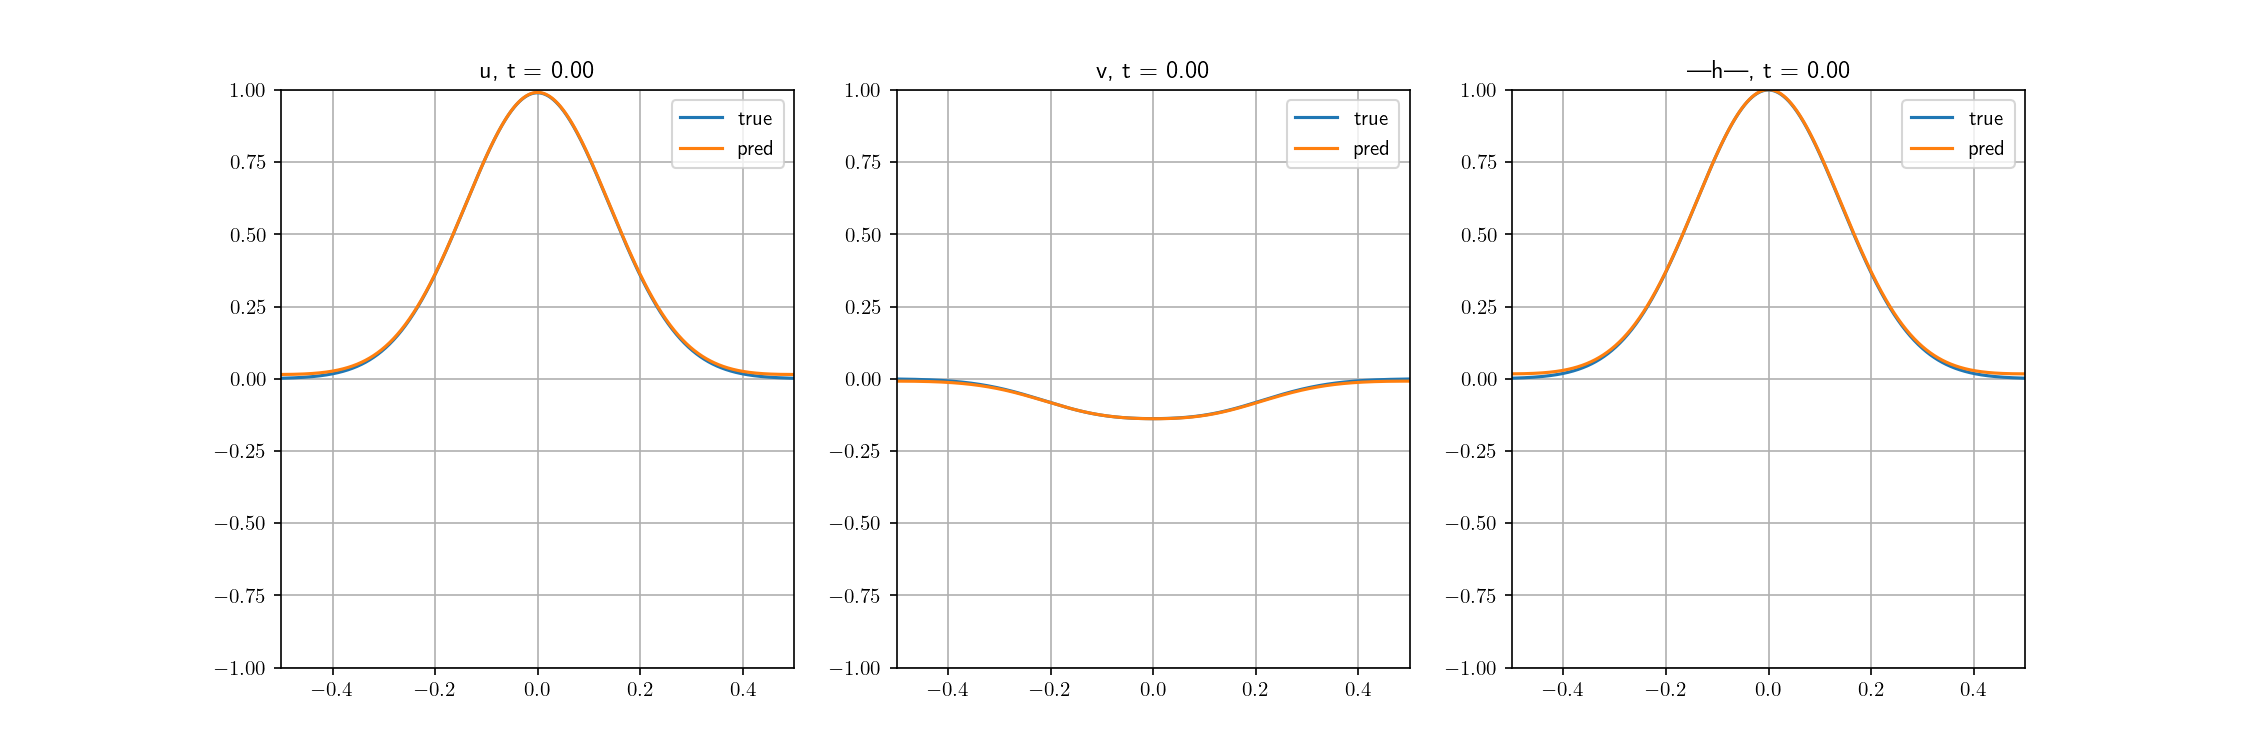

In [25]:
from scipy.io import loadmat

uv_true = loadmat("ex1_extended_epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([-0.5, 0.5])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 501)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 100, blit = True)
plt.show()

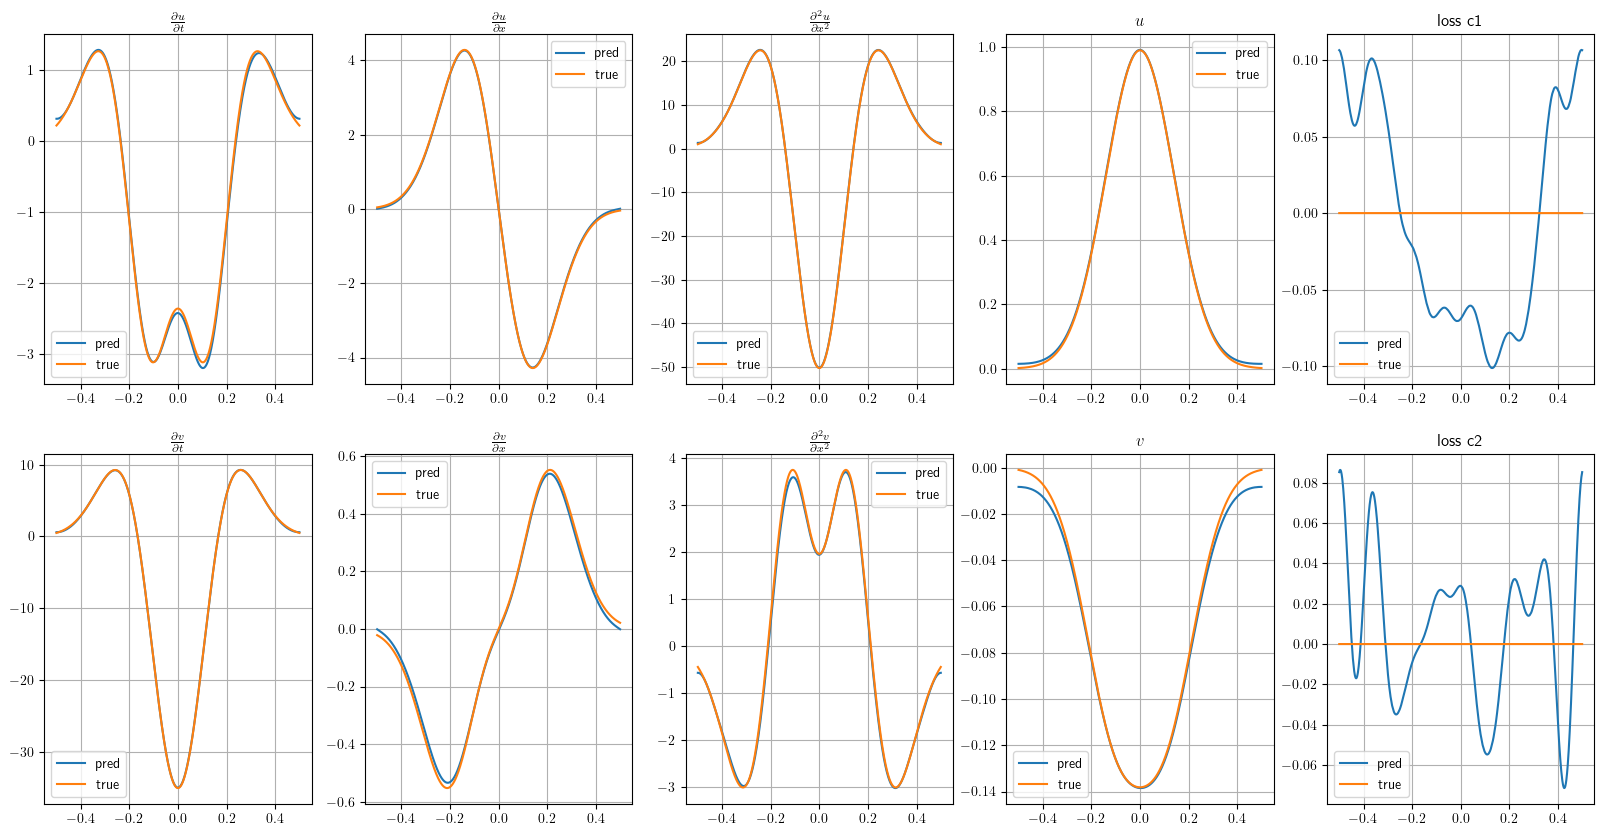

In [26]:
x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
t = jnp.zeros_like(x)
xt = jnp.hstack([x, t])


# direct_params_ = direct_params
direct_params_ = get_params(opt_state)
duv_dxt = jacobian(direct_params_, xt)
du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
duv_dxxtt = hessian(direct_params_, xt)
du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
uv = model(direct_params_, xt)
u, v = uv[:, 0:1], uv[:, 1:2]
loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["text.usetex"] = True

f, ax = plt.subplots(2, 5, figsize = (20, 10))
i, j = 0, 0
ax[i][j].plot(x, du_dt, label = "pred")
ax[i][j].plot(x, du0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
i = 1
ax[i][j].plot(x, dv_dt, label = "pred")
ax[i][j].plot(x, dv0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dx, label = "pred")
ax[i][j].plot(x, du0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
i = 1
ax[i][j].plot(x, dv_dx, label = "pred")
ax[i][j].plot(x, dv0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dxx, label = "pred")
ax[i][j].plot(x, du0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
i = 1
ax[i][j].plot(x, dv_dxx, label = "pred")
ax[i][j].plot(x, dv0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
i, j = 0, j+1
ax[i][j].plot(x, u, label = "pred")
ax[i][j].plot(x, u0, label = "true")
ax[i][j].set_title(r"$u$")
i = 1
ax[i][j].plot(x, v, label = "pred")
ax[i][j].plot(x, v0, label = "true")
ax[i][j].set_title(r"$v$")
i, j = 0, j+1
ax[i][j].plot(x, loss_c1, label = "pred")
ax[i][j].plot(x, loss_c10, label = "true")
ax[i][j].set_title(r"loss c1")
i = 1
ax[i][j].plot(x, loss_c2, label = "pred")
ax[i][j].plot(x, loss_c20, label = "true")
ax[i][j].set_title(r"loss c2")

for i in range(2):
	for j in range(5):
		ax[i][j].legend()
		ax[i][j].grid()
plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))